In [1]:
## 13/11/23: moved into a v2, in which we keep all models in for panel plots
## (v1 threw out extra models from the same family)
## V3: add obs colors to scatters, and tidy for sharing. 

## v4: make fontzises more consistent, and tidy 11/03/2024

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import json
import cftime
from itertools import product
from cftime import DatetimeNoLeap
import esmvalcore.preprocessor
import xesmf as xe
from xmip.preprocessing import promote_empty_dims, broadcast_lonlat, replace_x_y_nominal_lat_lon, rename_cmip6
from tqdm import tqdm
import dask
from scipy import stats
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator

alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l',
               'm','n','o','p','q','r','s','t','u','v','w','x','y','z']

In [38]:
# read in obs:
winter_months = [11, 12, 1, 2, 3]

#MOSAiC_file = '../Processed_obs/MOSAiC_merged.csv'
MOSAiC_file = '../Processed_obs/MOSAiC_merged.csv'
df_M = pd.read_csv(MOSAiC_file)
df_M['Campaign'] = 'MOSAiC'
df_M['t0'] = df_M['temp_2m']
df_M['surf_wind_velocity'] = df_M['wspd_tower_2m']

SHEBA_file = '../Processed_obs/SHEBA_merged.csv'
df_S = pd.read_csv(SHEBA_file)
df_S['Campaign'] = 'SHEBA'


NP_file = '../Processed_obs/NP.csv'
df_N = pd.read_csv(NP_file)
df_N['Campaign'] = 'NP'

df_C = df_N[np.isin(df_N['CLOUD_AMOUNT_QLTY'],[0,1,4])]
df_C['Cloudy_TF'] = np.where(df_C['CLOUD_AMOUNT']> 5, 'Cloudy', 'Clear')

DF_obs = pd.concat([df_M, df_S, df_N])
Campaigns = DF_obs['Campaign'].unique()

DF_obs['T_aloft'] = DF_obs['low_level_stability'] + DF_obs['t0']

DF_obs = DF_obs[DF_obs['month'].isin(winter_months)]
DF_obs.columns

/tmp/ipykernel_521/3260691451.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_C['Cloudy_TF'] = np.where(df_C['CLOUD_AMOUNT']> 5, 'Cloudy', 'Clear')


Index(['time', 't0', 'dt0', 'month', 'lon', 'lat', 'inversion_strength',
       'inversion_height', 'low_level_stability', 't_850hpa', 'rh_sub_850',
       'surf_wind_velocity', 'wind_shear', 'dt_', 'temp_2m',
       'down_long_hemisp', 'up_long_hemisp', 'lat_tower', 'lon_tower',
       'wspd_u_mean_2m', 'wspd_v_mean_2m', 'wspd_u_mean_6m', 'wspd_v_mean_6m',
       'wspd_u_mean_10m', 'wspd_v_mean_10m', 'wspd_tower_2m', 'wspd_tower_6m',
       'wspd_tower_10m', 'rlns', 'Campaign', 'Unnamed: 0.1', 'Unnamed: 0',
       'rlus', 'rlds', 'T_surf', 'station', 'SNT_IND', 'ELEV', 'year', 'day',
       'GMT_hour', 'GMT_minute', 'STD_GMT_TIME', 'local_time', 'RELSE_TIME',
       'latitude', 'longitude', 'min_altitude', 'max_altitude', 'OBSN_TYPE',
       'QC_EFFORT', 'DATA_SRCE', 'NUM_LVLS', 'INST_CODE', 'CLOUD_AMOUNT',
       'CLOUD_AMOUNT_QLTY', 'LOWER_CLOUD', 'CLOUD_HEIGHT', 'CLOUD_HEIGHT_QLTY',
       'MID_CLOUD', 'MID_CLOUD_QLTY', 'HIGH_CLOUD', 'HIGH_CLOUD_QLTY', 'date',
       'npoints', 'np

In [39]:
lm, ls = len(df_M.dropna(subset=['low_level_stability', 'rlns'])), len(df_S.dropna(subset=['low_level_stability', 'rlns']))
print(lm, ls, lm+ls)


303 289 592


In [40]:
### repeat with sondes obs for full set of sondes:


# read in obs:
winter_months = [11, 12, 1, 2, 3]

MOSAiC_file = '../Processed_obs/MOSAiC_sondes.csv'
df_M = pd.read_csv(MOSAiC_file)
df_M['Campaign'] = 'MOSAiC'
#df_M['t0'] = df_M['temp_2m']

SHEBA_file = '../Processed_obs/SHEBA_sondes.csv'
df_S = pd.read_csv(SHEBA_file)
df_S['Campaign'] = 'SHEBA'


NP_file = '../Processed_obs/NP.csv'
df_N = pd.read_csv(NP_file)
df_N['Campaign'] = 'NP'

df_C = df_N[np.isin(df_N['CLOUD_AMOUNT_QLTY'],[0,1,4])]
df_C['Cloudy_TF'] = np.where(df_C['CLOUD_AMOUNT']> 5, 'Cloudy', 'Clear')


DF_sondes = pd.concat([df_M, df_S, df_N])

DF_sondes['T_aloft'] = DF_sondes['low_level_stability'] + DF_sondes['t0']

DF_sondes = DF_sondes[DF_sondes['month'].isin(winter_months)]
DF_sondes.columns

/tmp/ipykernel_521/2405975885.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_C['Cloudy_TF'] = np.where(df_C['CLOUD_AMOUNT']> 5, 'Cloudy', 'Clear')


Index(['Unnamed: 0', 't0', 'dt0', 'month', 'lon', 'lat', 'inversion_strength',
       'inversion_height', 'low_level_stability', 't_850hpa', 'rh_sub_850',
       'surf_wind_velocity', 'wind_shear', 'dt_', 'Campaign', 'station',
       'SNT_IND', 'ELEV', 'year', 'day', 'GMT_hour', 'GMT_minute',
       'STD_GMT_TIME', 'local_time', 'RELSE_TIME', 'latitude', 'longitude',
       'min_altitude', 'max_altitude', 'OBSN_TYPE', 'QC_EFFORT', 'DATA_SRCE',
       'NUM_LVLS', 'INST_CODE', 'CLOUD_AMOUNT', 'CLOUD_AMOUNT_QLTY',
       'LOWER_CLOUD', 'CLOUD_HEIGHT', 'CLOUD_HEIGHT_QLTY', 'MID_CLOUD',
       'MID_CLOUD_QLTY', 'HIGH_CLOUD', 'HIGH_CLOUD_QLTY', 'date', 'npoints',
       'npoints_sub3000', 'cloudiness', 'cloud_quality', 'T_aloft'],
      dtype='object')

In [41]:
DF_obs.columns

Index(['time', 't0', 'dt0', 'month', 'lon', 'lat', 'inversion_strength',
       'inversion_height', 'low_level_stability', 't_850hpa', 'rh_sub_850',
       'surf_wind_velocity', 'wind_shear', 'dt_', 'temp_2m',
       'down_long_hemisp', 'up_long_hemisp', 'lat_tower', 'lon_tower',
       'wspd_u_mean_2m', 'wspd_v_mean_2m', 'wspd_u_mean_6m', 'wspd_v_mean_6m',
       'wspd_u_mean_10m', 'wspd_v_mean_10m', 'wspd_tower_2m', 'wspd_tower_6m',
       'wspd_tower_10m', 'rlns', 'Campaign', 'Unnamed: 0.1', 'Unnamed: 0',
       'rlus', 'rlds', 'T_surf', 'station', 'SNT_IND', 'ELEV', 'year', 'day',
       'GMT_hour', 'GMT_minute', 'STD_GMT_TIME', 'local_time', 'RELSE_TIME',
       'latitude', 'longitude', 'min_altitude', 'max_altitude', 'OBSN_TYPE',
       'QC_EFFORT', 'DATA_SRCE', 'NUM_LVLS', 'INST_CODE', 'CLOUD_AMOUNT',
       'CLOUD_AMOUNT_QLTY', 'LOWER_CLOUD', 'CLOUD_HEIGHT', 'CLOUD_HEIGHT_QLTY',
       'MID_CLOUD', 'MID_CLOUD_QLTY', 'HIGH_CLOUD', 'HIGH_CLOUD_QLTY', 'date',
       'npoints', 'np

In [8]:
DF = pd.DataFrame()

dir = 'sea_ice_hourly_inversions/'
for file in os.listdir(dir):
    if '.csv' in file:
        model = file.split('_')[0]
        ens_mem = file.split('_')[1]
        df = pd.read_csv(dir+file)
        df['Model'] = model
        df['Ens_mem'] = ens_mem
        DF = pd.concat([DF, df])

## keep only first ens member for now:
print(len(DF))
DF = DF[DF['Ens_mem'].str.contains('r1i')]
print(len(DF))


DF['wind_speed_surface'] = (DF['vas']**2 + DF['uas']**2)**(1/2)
DF['wind_speed_aloft'] = (DF['va']**2 + DF['ua']**2)**(1/2)
DF['wind_shear'] =  DF['wind_speed_aloft'] - DF['wind_speed_surface']

## convert tas to °C
DF['tas'] = DF['tas']-273.15

DF['T_aloft'] = DF['LLS'] + DF['tas']

1784856
1784856


In [9]:
dirs_df = pd.read_csv('models_and_dirs.csv')
mod = 'TaiESM1'
print(dirs_df[dirs_df['Model']==mod]['freq'].values)

['1D']


In [10]:
len(DF.Model.unique())

20

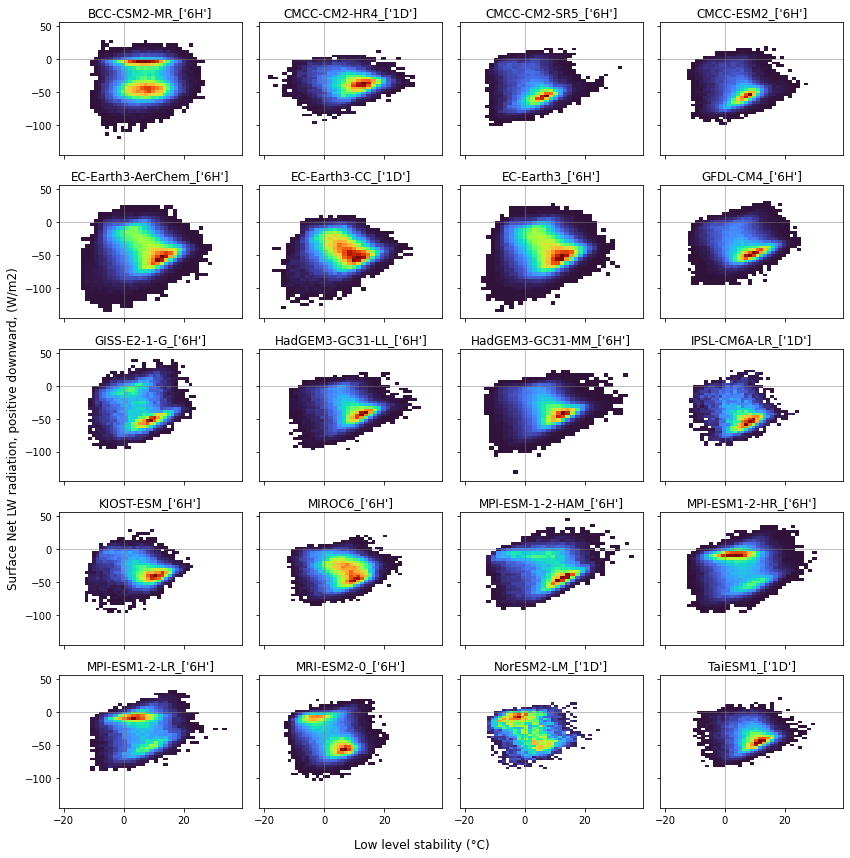

In [11]:
dirs_df = pd.read_csv('models_and_dirs.csv')

cols=4
N = len(DF['Model'].unique())
fig, axs = plt.subplots(nrows=int(N/cols), ncols=cols, figsize=(12,12), sharex=True, sharey=True)
i=0
models = DF['Model'].unique()
for mod in models:
    plt_data = DF[DF['Model']==mod]
    plt_data = plt_data[['LLS', 'rlns']].dropna()
    sns.histplot(data=plt_data,
                x ='LLS', y='rlns',
                ax = axs.flatten()[i],
                cmap='turbo', bins=30)
    #
    freq = str(dirs_df[dirs_df['Model']==mod]['freq'].values)
    axs.flatten()[i].set_title(mod+'_'+freq)
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    axs.flatten()[i].axhline(y=0, color='gray', lw=0.5)
    axs.flatten()[i].axvline(x=0, color='gray', lw=0.5)
    
    i=i+1
    
fig.supxlabel('Low level stability (°C)')
fig.supylabel('Surface Net LW radiation, positive downward, (W/m2)')
plt.tight_layout()
    #sns.histplot(ax = axs[i], data=DF[DF['Region']==region],
    #            x="LLS", hue="Model", bins=30)
    #i=i+1
plt.savefig('Figures/LLS_rlns_Hists_ALL_mods.png', dpi=300)

In [12]:
## now restrict to only 1 model per family
"""
mods_to_keep = ['TaiESM1', 'BCC-CSM2-MR', 'CMCC-ESM2', 
                'EC-Earth3', 'KIOST-ESM', 'MPI-ESM-1-2-HAM', 
                'MPI-ESM1-2-HR', 'MIROC6', 'HadGEM3-GC31-MM',
                'MRI-ESM2-0', 'GFDL-CM4', 'NorESM2-LM', 
                'GISS-E2-1-G', 'IPSL-CM6A-LR', 'EC-Earth3-CC']
"""
"""
mods_to_keep = ['BCC-CSM2-MR', 'CMCC-ESM2', 
                'EC-Earth3', 'KIOST-ESM',  
                'MPI-ESM1-2-HR', 'MIROC6', 'HadGEM3-GC31-MM',
                'MRI-ESM2-0', 'GFDL-CM4', 
                'GISS-E2-1-G']
"""
#DF = DF[DF['Model'].isin(mods_to_keep)]
N = len(DF['Model'].unique())
print(N)
DF

20


,Unnamed: 0,LLS,rlns,tas,vas,uas,va,ua,Model,Ens_mem,wind_speed_surface,wind_speed_aloft,wind_shear,T_aloft
0,5848741,7.770721,-5.910233,-20.20579,1.365942,1.955270,-2.394641,13.283873,BCC-CSM2-MR,r1i1p1f1.csv,2.385137,13.497985,11.112847,-12.435069
1,19258992,8.400528,-42.208405,-28.27532,-3.465384,3.829242,-15.150627,8.213885,BCC-CSM2-MR,r1i1p1f1.csv,5.164492,17.233961,12.069469,-19.874792
2,13895096,9.953934,-51.886840,-28.59812,-0.680879,-0.977372,2.458712,0.294524,BCC-CSM2-MR,r1i1p1f1.csv,1.191156,2.476289,1.285133,-18.644186
3,24942662,11.823578,-53.499443,-29.19944,-3.451945,-0.731851,-4.263270,-1.681468,BCC-CSM2-MR,r1i1p1f1.csv,3.528672,4.582882,1.054210,-17.375862
4,44932723,13.317841,-51.418976,-23.95978,2.571790,0.452715,7.463458,-2.411044,BCC-CSM2-MR,r1i1p1f1.csv,2.611332,7.843235,5.231903,-10.641939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27783,3848654,17.026428,-34.240295,-26.00065,NaN,NaN,NaN,NaN,TaiESM1,r1i1p1f1.csv,NaN,NaN,NaN,-8.974222
27784,4279381,15.366638,-40.667877,-36.29662,NaN,NaN,NaN,NaN,TaiESM1,r1i1p1f1.csv,NaN,NaN,NaN,-20.929982
27785,1315287,8.547913,-30.932587,-32.78695,NaN,NaN,NaN,NaN,TaiESM1,r1i1p1f1.csv,NaN,NaN,NaN,-24.239037
27786,55930,13.558578,-41.823500,-34.55990,NaN,NaN,NaN,NaN,TaiESM1,r1i1p1f1.csv,NaN,NaN,NaN,-21.001321


In [13]:
"""
### make the 1d lls histograms fig:

### repeat the above, just with fig b

#### KDE plot with obs
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
i=0


models = DF['Model'].unique()
for mod in models:
    plt_data = DF[DF['Model']==mod]['LLS'].sample(frac=0.05)
    #axs[i].hist(plt_data, bins = 50, histtype='step', density=True)
    sns.kdeplot(ax = ax, data=plt_data, color='gray', lw=0.5)
#            x="LLS", hue="Model", bins=30)
    #label=mod)
    #axs[i].legend()
    #ax.set_title(titles[region], fontsize='large')
#sns.kdeplot(ax = ax, data=data['LLS'].sample(frac=0.001), color='black',
#            lw=3)


ax.set_xlim([-25, 25])
ax.legend()

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

#plt.savefig('Figures/Mean_LLS_PDFs_with_obs_justSI_extra_NP_lines.jpg', dpi=450)
"""

'\n###\xa0make the 1d lls histograms fig:\n\n### repeat the above, just with fig b\n\n#### KDE plot with obs\nimport matplotlib\nmatplotlib.rcParams.update({\'font.size\': 16})\n\nfig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))\ni=0\n\n\nmodels = DF[\'Model\'].unique()\nfor mod in models:\n    plt_data = DF[DF[\'Model\']==mod][\'LLS\'].sample(frac=0.05)\n    #axs[i].hist(plt_data, bins = 50, histtype=\'step\', density=True)\n    sns.kdeplot(ax = ax, data=plt_data, color=\'gray\', lw=0.5)\n#            x="LLS", hue="Model", bins=30)\n    #label=mod)\n    #axs[i].legend()\n    #ax.set_title(titles[region], fontsize=\'large\')\n#sns.kdeplot(ax = ax, data=data[\'LLS\'].sample(frac=0.001), color=\'black\',\n#            lw=3)\n\n\nax.set_xlim([-25, 25])\nax.legend()\n\nplt.tight_layout()\nplt.subplots_adjust(hspace=0.3)\n\n#plt.savefig(\'Figures/Mean_LLS_PDFs_with_obs_justSI_extra_NP_lines.jpg\', dpi=450)\n'

### LLS dependence on surface temperature

In [14]:
import matplotlib

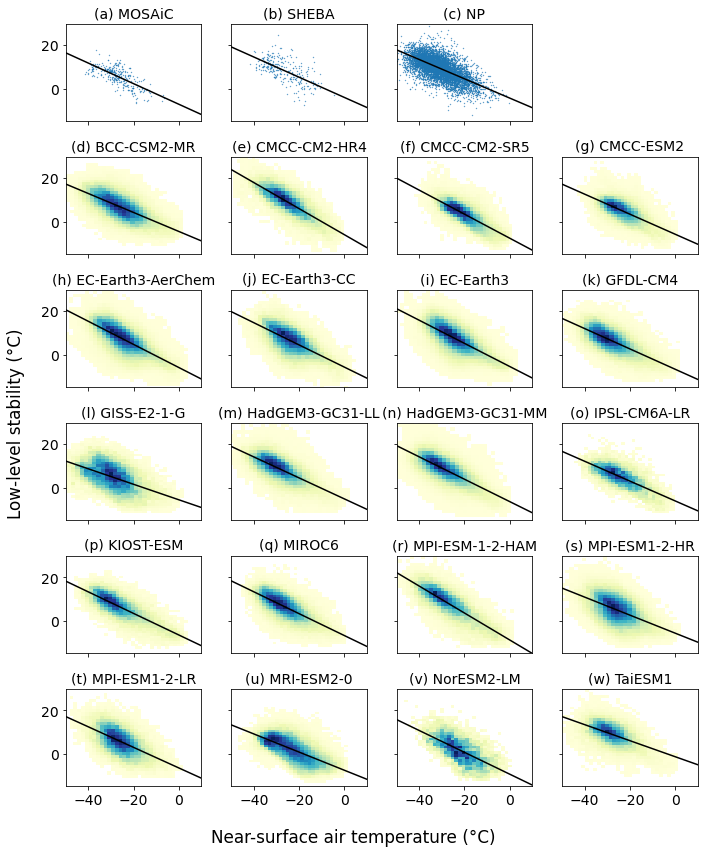

In [15]:
matplotlib.rcParams.update({'font.size': 14})

lets=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w']
cols=4
var_x, var_y = 'tas', 'LLS'
xtxt=0.65
ytxt=0.8
xlims = [-50, 10]
ylims = [-15, 30]

fig, axs = plt.subplots(nrows=int(N/cols)+1, ncols=cols, figsize=(10,12), sharex=True, sharey=True)

i=0
x_eg = -30
labels_egs = []
y_egs = []

for campaign in Campaigns:
    plt_data = DF_obs[DF_obs['Campaign']==campaign]
    plt_data = plt_data[['t0', 'low_level_stability']].dropna()
    axs.flatten()[i].scatter(x =plt_data['t0'], y=plt_data['low_level_stability'], s=0.1)
    regression = stats.linregress(x=plt_data['t0'].astype(float), y=plt_data['low_level_stability'].astype(float))
    r2 = np.round((regression.rvalue)**2, 2)
    slope = np.round(regression.slope, 2)
    xs= np.arange(xlims[0], xlims[1], 0.1)
    ys = (regression.slope*xs)+regression.intercept
    y_eg = (regression.slope*x_eg)+regression.intercept
    labels_egs.append(campaign)
    y_egs.append(y_eg)
    axs.flatten()[i].plot(xs, ys, c='black')
    #            
    axs.flatten()[i].set_title(str('('+lets[i]+')'+' '+campaign), fontsize='medium')
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    #axs.flatten()[i].text(xtxt, ytxt, 'R\u00b2: '+str(r2), horizontalalignment='left',
    # verticalalignment='center', transform=axs.flatten()[i].transAxes)
    #axs.flatten()[i].text(xtxt, ytxt+0.1, 'm: '+str(slope), horizontalalignment='left',
    # verticalalignment='center', transform=axs.flatten()[i].transAxes)
    
    i=i+1


i=cols
models = DF['Model'].unique()
for mod in models:
    plt_data = DF[DF['Model']==mod]
    plt_data = plt_data[['tas', 'LLS']].dropna()
    sns.histplot(data=plt_data,
                x ='tas', y='LLS',
                ax = axs.flatten()[i],
                cmap='YlGnBu', bins=30)
    regression = stats.linregress(x=plt_data[var_x].astype(float), y=plt_data[var_y].astype(float))
    r2 = np.round((regression.rvalue)**2, 2)
    slope = np.round(regression.slope, 2)
    
    xs= np.arange(xlims[0], xlims[1], 0.1)
    ys = (regression.slope*xs)+regression.intercept
    y_eg = (regression.slope*x_eg)+regression.intercept
    labels_egs.append(mod)
    y_egs.append(y_eg)
    axs.flatten()[i].plot(xs, ys, c='black')
    #            
    axs.flatten()[i].set_title(str('('+lets[i-1]+')'+' '+mod), fontsize='medium')
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    #axs.flatten()[i].text(xtxt, ytxt, 'R\u00b2: '+str(r2), horizontalalignment='left',
    # verticalalignment='center', transform=axs.flatten()[i].transAxes)
    #axs.flatten()[i].text(xtxt, ytxt+0.1, 'm: '+str(slope), horizontalalignment='left',
    # verticalalignment='center', transform=axs.flatten()[i].transAxes)
    
    i=i+1
for ax in axs.flatten():
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
fig.supxlabel('Near-surface air temperature (°C)')
fig.supylabel('Low-level stability (°C)')
plt.tight_layout()
axs.flatten()[3].remove()
    #sns.histplot(ax = axs[i], data=DF[DF['Region']==region],
    #            x="LLS", hue="Model", bins=30)
    #i=i+1
plt.savefig('Figures/LLS_tas_Hists_regs_no_mods_dropped.jpg', dpi=450)
plt.show()

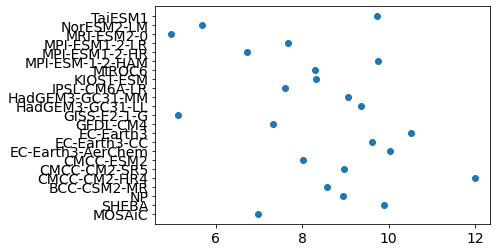

In [16]:
plt.scatter(y_egs, labels_egs)

0.5166666666666667
0.5145000000000001


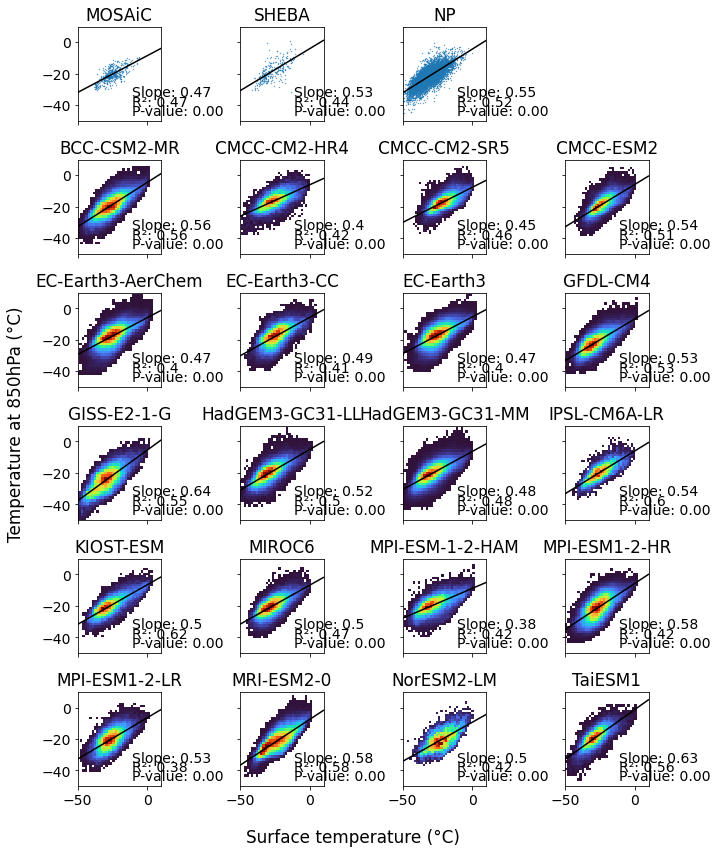

In [17]:
cols=4
var_x, var_y = 'tas', 'T_aloft'
xtxt=0.65
ytxt=0.1
xlims = [-50, 10]
ylims = [-50, 10]

fig, axs = plt.subplots(nrows=int(N/cols)+1, ncols=cols, figsize=(10,12), sharex=True, sharey=True)
camp_slopes = []
i=0
for campaign in Campaigns:
    plt_data = DF_sondes[DF_sondes['Campaign']==campaign]
    plt_data = plt_data[['t0', 'T_aloft']].dropna()
    axs.flatten()[i].scatter(x =plt_data['t0'], y=plt_data['T_aloft'], s=0.1)
    regression = stats.linregress(x=plt_data['t0'].astype(float), y=plt_data['T_aloft'].astype(float))
    r2 = np.round((regression.rvalue)**2, 2)
    slope = np.round(regression.slope, 2)
    camp_slopes.append(slope)
    pval = str("%.2f" % regression.pvalue)
    xs= np.arange(xlims[0], xlims[1], 0.1)
    ys = (regression.slope*xs)+regression.intercept
    axs.flatten()[i].plot(xs, ys, c='black')
    #            
    axs.flatten()[i].set_title(campaign)
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    axs.flatten()[i].text(xtxt, ytxt, 'P-value: '+str(pval), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    axs.flatten()[i].text(xtxt, ytxt+0.1, 'R\u00b2: '+str(r2), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    axs.flatten()[i].text(xtxt, ytxt+0.2, 'Slope: '+str(slope), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    
    i=i+1

slopes = []
i=cols
models = DF['Model'].unique()
for mod in models:
    plt_data = DF[DF['Model']==mod]
    plt_data = plt_data[['tas', 'T_aloft']].dropna()
    sns.histplot(data=plt_data,
                x ='tas', y='T_aloft',
                ax = axs.flatten()[i],
                cmap='turbo', bins=30)
    regression = stats.linregress(x=plt_data[var_x].astype(float), y=plt_data[var_y].astype(float))
    r2 = np.round((regression.rvalue)**2, 2)
    slope = np.round(regression.slope, 2)
    slopes.append(slope)
    pval = str("%.2f" % regression.pvalue)
    xs= np.arange(xlims[0], xlims[1], 0.1)
    ys = (regression.slope*xs)+regression.intercept
    axs.flatten()[i].plot(xs, ys, c='black')
    #            
    axs.flatten()[i].set_title(mod)
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    axs.flatten()[i].text(xtxt, ytxt, 'P-value: '+str(pval), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    axs.flatten()[i].text(xtxt, ytxt+0.1, 'R\u00b2: '+str(r2), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    axs.flatten()[i].text(xtxt, ytxt+0.2, 'Slope: '+str(slope), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    
    i=i+1
for ax in axs.flatten():
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
fig.supxlabel('Surface temperature (°C)')
fig.supylabel('Temperature at 850hPa (°C)')
plt.tight_layout()
axs.flatten()[3].remove()
    
plt.savefig('Figures/Taloft_tas_Hists_regs.png', dpi=300)
print(np.mean(camp_slopes))
print(np.mean(slopes))

/tmp/ipykernel_521/1378614255.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_C['T_aloft'] = df_C['low_level_stability'] + df_C['t0']


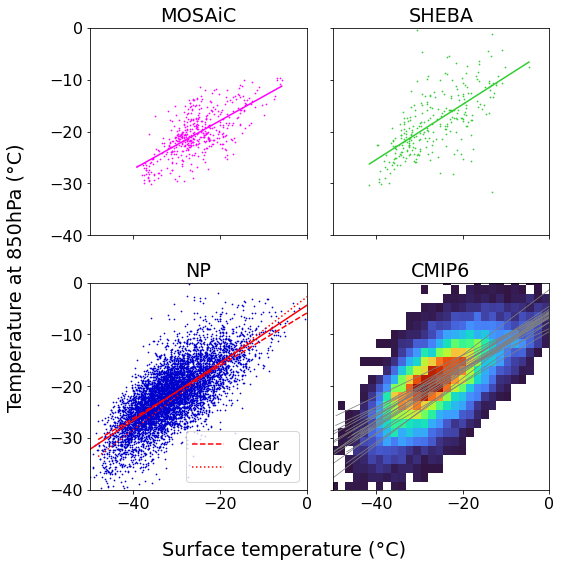

[0.47, 0.53, 0.55]


In [18]:

plt.rcParams.update({'font.size': 16})


linecolors = {'NP': 'red', 'SHEBA': 'limegreen', 'MOSAiC': 'magenta'}

colors = {'MOSAiC': 'magenta',
          'SHEBA': 'limegreen',
          'NP': 'mediumblue'}

df_C['T_aloft'] = df_C['low_level_stability'] + df_C['t0']


var_x, var_y = 'tas', 'T_aloft'
xtxt=0.65
ytxt=0.1
xlims = [-50, 0]
ylims = [-40, 0]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8), sharex=True, sharey=True)
obs_slopes = []
i=0
for campaign in ['MOSAiC', 'SHEBA', 'NP']:
    plt_data = DF_sondes[DF_sondes['Campaign']==campaign]
    plt_data = plt_data[['t0', 'T_aloft']].dropna()
    regression = stats.linregress(x=plt_data['t0'].astype(float), y=plt_data['T_aloft'].astype(float))
    r2 = np.round((regression.rvalue)**2, 2)
    slope = np.round(regression.slope, 2)
    obs_slopes.append(slope)
    xs= np.arange(np.min(plt_data['t0']), np.max(plt_data['t0']), 0.1)
    ys = (regression.slope*xs)+regression.intercept
    
    axs.flatten()[i].scatter(x =plt_data['t0'], y=plt_data['T_aloft'],
                         c=colors[campaign], s=0.5)
    axs.flatten()[i].plot(xs, ys, c=linecolors[campaign])
    #            
    axs.flatten()[i].set_title(campaign)
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    i=i+1
    """
    axs.flatten()[i].text(xtxt, ytxt, 'R2: '+str(r2), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    axs.flatten()[i].text(xtxt, ytxt+0.1, 'Slope: '+str(slope), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    """
        
i=2
NP_linestyles={'Clear':'dashed', 'Cloudy':'dotted'}   
l=0
for cloudiness in ['Clear', 'Cloudy']:
    plt_data = df_C[df_C['Cloudy_TF']==cloudiness]
    plt_data = plt_data[['t0', 'T_aloft']].dropna()
    #axs.flatten()[i].scatter(x =plt_data['t0'], y=plt_data['T_aloft'],
    #                         c=NP_colors[l], s=0.5)
    regression = stats.linregress(x=plt_data['t0'].astype(float), y=plt_data['T_aloft'].astype(float))
    r2 = np.round((regression.rvalue)**2, 2)
    slope = np.round(regression.slope, 2)
    xs= np.arange(np.min(plt_data['t0']), np.max(plt_data['t0']), 0.1)
    ys = (regression.slope*xs)+regression.intercept
    axs.flatten()[i].plot(xs, ys, c='red', linestyle=NP_linestyles[cloudiness], label=cloudiness)
    #            
    axs.flatten()[i].set_title('NP')
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    axs.flatten()[i].legend()
    l=l+1
    """
    axs.flatten()[i].text(xtxt, ytxt, 'R2: '+str(r2), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    axs.flatten()[i].text(xtxt, ytxt+0.1, 'Slope: '+str(slope), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    """
obs_slopes_dict = dict(zip(['MOSAiC', 'SHEBA', 'NP'], obs_slopes))    
    
i=3
models = DF['Model'].unique()
plt_data = DF[['tas', 'T_aloft']].dropna().sample(frac=0.01).reset_index()
sns.histplot(data=plt_data,
                x ='tas', y='T_aloft',
                ax = axs.flatten()[i],
                cmap='turbo', bins=30)
mod_slopes = []
for mod in models:
    plt_data = DF[DF['Model']==mod]
    plt_data = plt_data[['tas', 'T_aloft']].dropna()
    regression = stats.linregress(x=plt_data[var_x].astype(float), y=plt_data[var_y].astype(float))
    r2 = np.round((regression.rvalue)**2, 2)
    slope = np.round(regression.slope, 2)
    mod_slopes.append(slope)
    xs= np.arange(np.min(plt_data['tas']), np.max(plt_data['tas']), 0.1)
    ys = (regression.slope*xs)+regression.intercept
    axs.flatten()[i].plot(xs, ys, c='gray', lw=0.75)
    #            
    axs.flatten()[i].set_title('CMIP6')
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
mod_slopes_dict = dict(zip(models, mod_slopes))
"""
axs.flatten()[i].text(xtxt, ytxt, 'R2: '+str(r2), horizontalalignment='left',
 verticalalignment='center', transform=axs.flatten()[i].transAxes)
axs.flatten()[i].text(xtxt, ytxt+0.1, 'Slope: '+str(slope), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
"""    
    
for ax in axs.flatten():
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
fig.supxlabel('Surface temperature (°C)')
fig.supylabel('Temperature at 850hPa (°C)')
plt.tight_layout()
    #sns.histplot(ax = axs[i], data=DF[DF['Region']==region],
    #            x="LLS", hue="Model", bins=30)
    #i=i+1
plt.savefig('Figures/Taloft_tas_summary_no_mods_dropped.jpg', dpi=450)
plt.show()
print(obs_slopes)

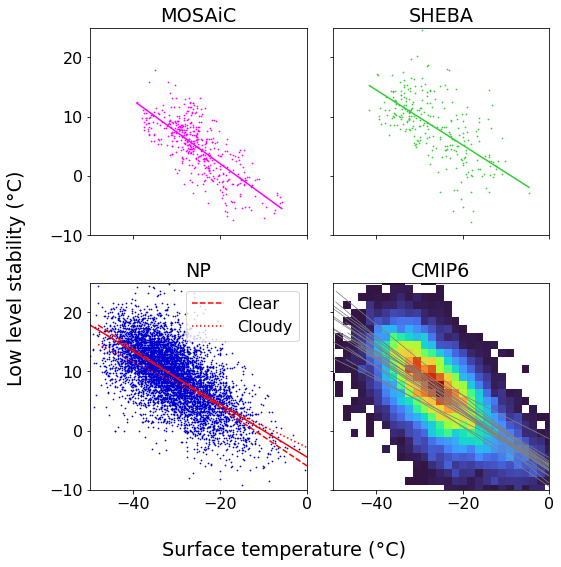

In [19]:
## repeat obs model comparison, now using LLS as y-axis. 
plt.rcParams.update({'font.size': 16})


linecolors = {'NP': 'red', 'SHEBA': 'limegreen', 'MOSAiC': 'magenta'}

colors = {'MOSAiC': 'magenta',
          'SHEBA': 'limegreen',
          'NP': 'mediumblue'}


var_x, var_y = 'tas', 'low_level_stability'
xtxt=0.65
ytxt=0.1
xlims = [-50, 0]
ylims = [-10, 25]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8), sharex=True, sharey=True)
obs_slopes = []
i=0
for campaign in ['MOSAiC', 'SHEBA', 'NP']:
    plt_data = DF_sondes[DF_sondes['Campaign']==campaign]
    plt_data = plt_data[['t0', 'low_level_stability']].dropna()
    regression = stats.linregress(x=plt_data['t0'].astype(float), y=plt_data['low_level_stability'].astype(float))
    r2 = np.round((regression.rvalue)**2, 2)
    slope = np.round(regression.slope, 2)
    obs_slopes.append(slope)
    xs= np.arange(np.min(plt_data['t0']), np.max(plt_data['t0']), 0.1)
    ys = (regression.slope*xs)+regression.intercept
    
    axs.flatten()[i].scatter(x =plt_data['t0'], y=plt_data['low_level_stability'],
                         c=colors[campaign], s=0.5)
    axs.flatten()[i].plot(xs, ys, c=linecolors[campaign])
    #            
    axs.flatten()[i].set_title(campaign)
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    i=i+1
    """
    axs.flatten()[i].text(xtxt, ytxt, 'R2: '+str(r2), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    axs.flatten()[i].text(xtxt, ytxt+0.1, 'Slope: '+str(slope), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    """
        
i=2
NP_linestyles={'Clear':'dashed', 'Cloudy':'dotted'}   
l=0
for cloudiness in ['Clear', 'Cloudy']:
    plt_data = df_C[df_C['Cloudy_TF']==cloudiness]
    plt_data = plt_data[['t0', 'low_level_stability']].dropna()
    #axs.flatten()[i].scatter(x =plt_data['t0'], y=plt_data['T_aloft'],
    #                         c=NP_colors[l], s=0.5)
    regression = stats.linregress(x=plt_data['t0'].astype(float), y=plt_data['low_level_stability'].astype(float))
    r2 = np.round((regression.rvalue)**2, 2)
    slope = np.round(regression.slope, 2)
    xs= np.arange(np.min(plt_data['t0']), np.max(plt_data['t0']), 0.1)
    ys = (regression.slope*xs)+regression.intercept
    axs.flatten()[i].plot(xs, ys, c='red', linestyle=NP_linestyles[cloudiness], label=cloudiness)
    #            
    axs.flatten()[i].set_title('NP')
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    axs.flatten()[i].legend()
    l=l+1
    """
    axs.flatten()[i].text(xtxt, ytxt, 'R2: '+str(r2), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    axs.flatten()[i].text(xtxt, ytxt+0.1, 'Slope: '+str(slope), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    """
obs_slopes_dict = dict(zip(['MOSAiC', 'SHEBA', 'NP'], obs_slopes))    
    
i=3
models = DF['Model'].unique()
plt_data = DF[['tas', 'LLS']].dropna().sample(frac=0.01).reset_index()
sns.histplot(data=plt_data,
                x ='tas', y='LLS',
                ax = axs.flatten()[i],
                cmap='turbo', bins=30)
mod_slopes = []
for mod in models:
    plt_data = DF[DF['Model']==mod]
    plt_data = plt_data[['tas', 'LLS']].dropna()
    regression = stats.linregress(x=plt_data['tas'].astype(float), y=plt_data['LLS'].astype(float))
    r2 = np.round((regression.rvalue)**2, 2)
    slope = np.round(regression.slope, 2)
    mod_slopes.append(slope)
    xs= np.arange(np.min(plt_data['tas']), np.max(plt_data['tas']), 0.1)
    ys = (regression.slope*xs)+regression.intercept
    axs.flatten()[i].plot(xs, ys, c='gray', lw=0.75)
    #            
    axs.flatten()[i].set_title('CMIP6')
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
mod_slopes_dict = dict(zip(models, mod_slopes))
"""
axs.flatten()[i].text(xtxt, ytxt, 'R2: '+str(r2), horizontalalignment='left',
 verticalalignment='center', transform=axs.flatten()[i].transAxes)
axs.flatten()[i].text(xtxt, ytxt+0.1, 'Slope: '+str(slope), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
"""    
    
for ax in axs.flatten():
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
fig.supxlabel('Surface temperature (°C)')
fig.supylabel('Low level stability (°C)')
plt.tight_layout()
    #sns.histplot(ax = axs[i], data=DF[DF['Region']==region],
    #            x="LLS", hue="Model", bins=30)
    #i=i+1

plt.savefig('Figures/LLS_tas_summary_no_mods_dropped.jpg', dpi=450)


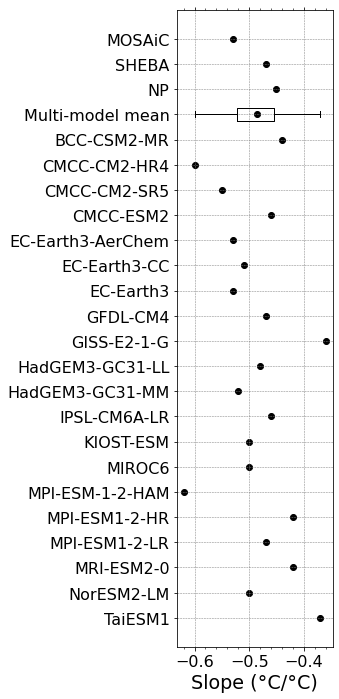

In [20]:
slopes = np.concatenate(([obs_slopes, [np.mean(mod_slopes)], mod_slopes]))
labels = np.concatenate(([['MOSAiC', 'SHEBA', 'NP'], ['Multi-model mean'], models]))

fig, ax = plt.subplots(figsize=(5, 10))

ax.boxplot(mod_slopes,positions=[len(models)],widths=0.5,
           showmeans=False,
           whis=[5, 95], showfliers=False,
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':8,
                      'markerfacecolor':'black',
                      'markeredgecolor':'black'},
          vert=False)


ax.scatter(np.flip(slopes), np.flip(labels), c='black')
ax.set_xlabel('Slope (°C/°C)',fontsize='large')

ax.tick_params(axis="x",direction="out", which='both', top=True, labeltop=False, bottom=True, labelbottom=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(np.flip(labels),rotation=0, fontsize='medium') 
plt.tight_layout()
#plt.savefig('Figures/model_obs_comparison_mean_state_lls.png', dpi=300)
plt.show()

In [21]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


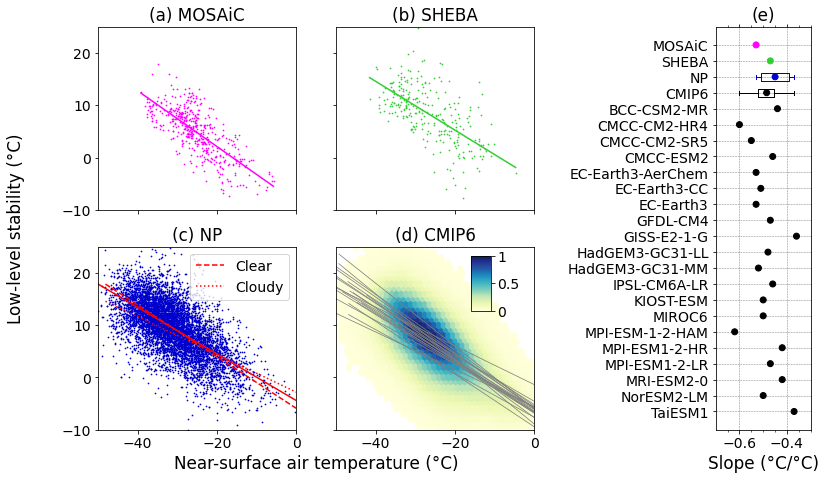

In [22]:
## repeat, now using LLS as y-axis, and including right hand plot with scatter of slopes


plt.rcParams.update({'font.size': 14})


linecolors = {'NP': 'red', 'SHEBA': 'limegreen', 'MOSAiC': 'magenta'}

colors = {'MOSAiC': 'magenta',
          'SHEBA': 'limegreen',
          'NP': 'mediumblue'}
colormap = 'YlGnBu'

scatter_colors_obs = [colors[campaign] for campaign in ['NP', 'SHEBA', 'MOSAiC']]
scatter_colors_mm_mean = ['black']
scatter_colors_mods = ['black' for i in models]
scatter_colors =  scatter_colors_mods + scatter_colors_mm_mean + scatter_colors_obs 


var_x, var_y = 'tas', 'low_level_stability'
xtxt=0.65
ytxt=0.1
xlims = [-50, 0]
ylims = [-10, 25]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,7), sharex=True, sharey=True)
obs_slopes = []
i=0
abc = ['(a) ', '(b) ', '(c) ']
for campaign in ['MOSAiC', 'SHEBA', 'NP']:
    plt_data = DF_sondes[DF_sondes['Campaign']==campaign]
    plt_data = plt_data[['t0', 'low_level_stability']].dropna()
    regression = stats.linregress(x=plt_data['t0'].astype(float), y=plt_data['low_level_stability'].astype(float))
    r2 = np.round((regression.rvalue)**2, 2)
    slope = np.round(regression.slope, 2)
    obs_slopes.append(slope)
    xs= np.arange(np.min(plt_data['t0']), np.max(plt_data['t0']), 0.1)
    ys = (regression.slope*xs)+regression.intercept
    
    axs.flatten()[i].scatter(x =plt_data['t0'], y=plt_data['low_level_stability'],
                         c=colors[campaign], s=0.5)
    axs.flatten()[i].plot(xs, ys, c=linecolors[campaign])
    #            
    axs.flatten()[i].set_title(abc[i]+campaign)
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    i=i+1
    """
    axs.flatten()[i].text(xtxt, ytxt, 'R2: '+str(r2), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    axs.flatten()[i].text(xtxt, ytxt+0.1, 'Slope: '+str(slope), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    """
        
i=2
NP_linestyles={'Clear':'dashed', 'Cloudy':'dotted'}   
l=0
for cloudiness in ['Clear', 'Cloudy']:
    plt_data = df_C[df_C['Cloudy_TF']==cloudiness]
    plt_data = plt_data[['t0', 'low_level_stability']].dropna()
    #axs.flatten()[i].scatter(x =plt_data['t0'], y=plt_data['T_aloft'],
    #                         c=NP_colors[l], s=0.5)
    regression = stats.linregress(x=plt_data['t0'].astype(float), y=plt_data['low_level_stability'].astype(float))
    r2 = np.round((regression.rvalue)**2, 2)
    slope = np.round(regression.slope, 2)
    xs= np.arange(np.min(plt_data['t0']), np.max(plt_data['t0']), 0.1)
    ys = (regression.slope*xs)+regression.intercept
    axs.flatten()[i].plot(xs, ys, c='red', linestyle=NP_linestyles[cloudiness], label=cloudiness)
    #            
    #axs.flatten()[i].set_title('NP')
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    axs.flatten()[i].legend()
    l=l+1
    """
    axs.flatten()[i].text(xtxt, ytxt, 'R2: '+str(r2), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    axs.flatten()[i].text(xtxt, ytxt+0.1, 'Slope: '+str(slope), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    """
obs_slopes_dict = dict(zip(['MOSAiC', 'SHEBA', 'NP'], obs_slopes))    
    
i=3
models = DF['Model'].unique()
#plt_data = DF[['tas', 'LLS']].dropna().sample(frac=0.01).reset_index()
plt_data = DF[['tas', 'LLS']].dropna().reset_index()
"""
h = sns.histplot(data=plt_data,
                x ='tas', y='LLS',
                ax = axs.flatten()[i],
                cmap=colormap, bins=30)
                """
h = axs.flatten()[i].hexbin(data=plt_data,
                            x ='tas', y='LLS',
                            cmap=colormap, gridsize=50, mincnt = 10)
axins = axs.flatten()[i].inset_axes([0.68, 0.65, 0.1, 0.3], )

func = lambda x,pos: "{:g}".format(x/np.max(h.get_array()))
fmt = matplotlib.ticker.FuncFormatter(func)
#axins.xaxis.set_ticks_position("bottom")
bar = plt.colorbar(h, cax=axins, orientation="vertical",
             format=fmt, ticks=[10, np.max(h.get_array())/2, np.max(h.get_array())],
             )
bar.ax.set_yticklabels(['0', '0.5', '1']) 

mod_slopes = []
for mod in models:
    plt_data = DF[DF['Model']==mod]
    plt_data = plt_data[['tas', 'LLS']].dropna()
    regression = stats.linregress(x=plt_data['tas'].astype(float), y=plt_data['LLS'].astype(float))
    r2 = np.round((regression.rvalue)**2, 2)
    slope = np.round(regression.slope, 2)
    mod_slopes.append(slope)
    xs= np.arange(np.min(plt_data['tas']), np.max(plt_data['tas']), 0.1)
    ys = (regression.slope*xs)+regression.intercept
    axs.flatten()[i].plot(xs, ys, c='gray', lw=0.75)
    #            
    axs.flatten()[i].set_title('(d) CMIP6')
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
mod_slopes_dict = dict(zip(models, mod_slopes))
"""
axs.flatten()[i].text(xtxt, ytxt, 'R2: '+str(r2), horizontalalignment='left',
 verticalalignment='center', transform=axs.flatten()[i].transAxes)
axs.flatten()[i].text(xtxt, ytxt+0.1, 'Slope: '+str(slope), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
"""    
    
for ax in axs.flatten():
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
axs.flatten()[3].set_xlabel('Near-surface air temperature (°C)', x=-0.1,fontsize='large')
#fig.supxlabel('Surface temperature (°C)')
fig.supylabel('Low-level stability (°C)',fontsize='large')
#plt.tight_layout()
    #sns.histplot(ax = axs[i], data=DF[DF['Region']==region],
    #            x="LLS", hue="Model", bins=30)
    #i=i+1

#plt.savefig('Figures/LLS_tas_summary.png', dpi=300)

slopes = np.concatenate(([obs_slopes, [np.mean(mod_slopes)], mod_slopes]))
labels = np.concatenate(([['MOSAiC', 'SHEBA', 'NP'], ['CMIP6'], models]))

#fig2, ax = plt.subplots(figsize=(5, 10))
plt.subplots_adjust(bottom=0.1, right=0.63, top=0.9)
cax = plt.axes((0.84, 0.1, 0.11, 0.8))
cax.boxplot(mod_slopes,positions=[len(models)],widths=0.5,
           showmeans=False,
           whis=[5, 95], showfliers=False,
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':8,
                      'markerfacecolor':'black',
                      'markeredgecolor':'black'},
          vert=False)

NP_slopes, camps = [], []
for station in DF_obs[DF_obs['Campaign']=='NP']['station'].unique():
    camps.append(campaign+'_'+str(station))
    plt_data = DF_obs[DF_obs['station']==station]
    plt_data = plt_data[['t0', 'low_level_stability']].dropna()
    regression = stats.linregress(x=plt_data['t0'].astype(float), y=plt_data['low_level_stability'].astype(float))
    NP_slope = np.round(regression.slope, 2)
    NP_slopes.append(NP_slope)
    
bpNP = cax.boxplot(NP_slopes,positions=[len(models)+1],widths=0.5,
           showmeans=False,
           whis=[5, 95], showfliers=False,
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':8,
                      'markerfacecolor':'black',
                      'markeredgecolor':'black'},
          vert=False)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bpNP[element], color=colors['NP'])

cax.scatter(np.flip(slopes), np.flip(labels), c=scatter_colors)
cax.set_xlabel('Slope (°C/°C)',fontsize='large')
cax.set_xlim([-0.7, -0.3])
cax.tick_params(axis="x",direction="out", which='both', top=True, labeltop=False, bottom=True, labelbottom=True)
cax.xaxis.set_minor_locator(AutoMinorLocator())
cax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
cax.set_axisbelow(True)
cax.set_yticks(np.arange(len(labels)))
cax.set_yticklabels(np.flip(labels),rotation=0, fontsize='medium') 
cax.set_title('(e)')
#plt.tight_layout()
plt.savefig('Figures/model_obs_comparison_mean_state_lls_no_mods_dropped.jpg', 
            dpi=450, bbox_inches='tight')
plt.show()


In [23]:
print(np.mean(mod_slopes))
print(stats.sem(mod_slopes))
print(np.std(mod_slopes))

-0.48549999999999993
0.014805315546149384
0.06453487429289687


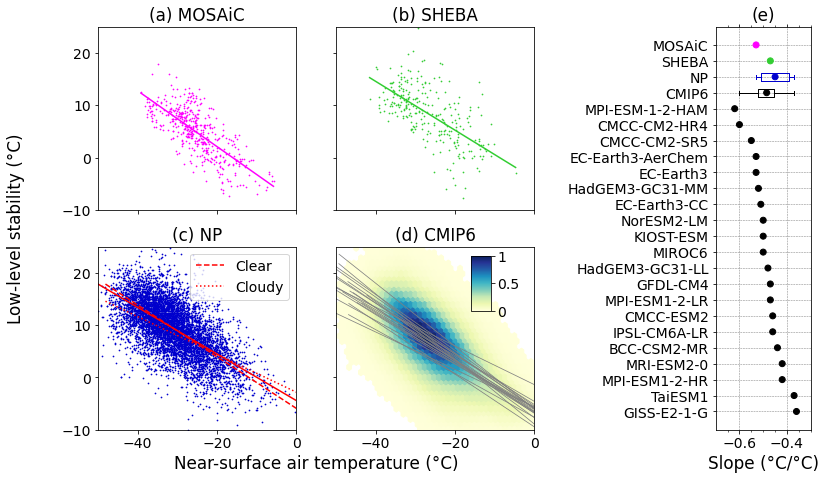

In [24]:
## repeat,the above plot, now with mods ordered by slope:


plt.rcParams.update({'font.size': 14})


linecolors = {'NP': 'red', 'SHEBA': 'limegreen', 'MOSAiC': 'magenta'}

colors = {'MOSAiC': 'magenta',
          'SHEBA': 'limegreen',
          'NP': 'mediumblue'}
colormap = 'YlGnBu'

scatter_colors_obs = [colors[campaign] for campaign in ['NP', 'SHEBA', 'MOSAiC']]
scatter_colors_mm_mean = ['black']
scatter_colors_mods = ['black' for i in models]
scatter_colors =  scatter_colors_mods + scatter_colors_mm_mean + scatter_colors_obs 


var_x, var_y = 'tas', 'low_level_stability'
xtxt=0.65
ytxt=0.1
xlims = [-50, 0]
ylims = [-10, 25]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,7), sharex=True, sharey=True)
obs_slopes = []
i=0
abc = ['(a) ', '(b) ', '(c) ']
for campaign in ['MOSAiC', 'SHEBA', 'NP']:
    plt_data = DF_sondes[DF_sondes['Campaign']==campaign]
    plt_data = plt_data[['t0', 'low_level_stability']].dropna()
    regression = stats.linregress(x=plt_data['t0'].astype(float), y=plt_data['low_level_stability'].astype(float))
    r2 = np.round((regression.rvalue)**2, 2)
    slope = np.round(regression.slope, 2)
    obs_slopes.append(slope)
    xs= np.arange(np.min(plt_data['t0']), np.max(plt_data['t0']), 0.1)
    ys = (regression.slope*xs)+regression.intercept
    
    axs.flatten()[i].scatter(x =plt_data['t0'], y=plt_data['low_level_stability'],
                         c=colors[campaign], s=0.5)
    axs.flatten()[i].plot(xs, ys, c=linecolors[campaign])
    #            
    axs.flatten()[i].set_title(abc[i]+campaign)
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    i=i+1
    """
    axs.flatten()[i].text(xtxt, ytxt, 'R2: '+str(r2), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    axs.flatten()[i].text(xtxt, ytxt+0.1, 'Slope: '+str(slope), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    """
        
i=2
NP_linestyles={'Clear':'dashed', 'Cloudy':'dotted'}   
l=0
for cloudiness in ['Clear', 'Cloudy']:
    plt_data = df_C[df_C['Cloudy_TF']==cloudiness]
    plt_data = plt_data[['t0', 'low_level_stability']].dropna()
    #axs.flatten()[i].scatter(x =plt_data['t0'], y=plt_data['T_aloft'],
    #                         c=NP_colors[l], s=0.5)
    regression = stats.linregress(x=plt_data['t0'].astype(float), y=plt_data['low_level_stability'].astype(float))
    r2 = np.round((regression.rvalue)**2, 2)
    slope = np.round(regression.slope, 2)
    xs= np.arange(np.min(plt_data['t0']), np.max(plt_data['t0']), 0.1)
    ys = (regression.slope*xs)+regression.intercept
    axs.flatten()[i].plot(xs, ys, c='red', linestyle=NP_linestyles[cloudiness], label=cloudiness)
    #            
    #axs.flatten()[i].set_title('NP')
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    axs.flatten()[i].legend()
    l=l+1
    """
    axs.flatten()[i].text(xtxt, ytxt, 'R2: '+str(r2), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    axs.flatten()[i].text(xtxt, ytxt+0.1, 'Slope: '+str(slope), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    """
obs_slopes_dict = dict(zip(['MOSAiC', 'SHEBA', 'NP'], obs_slopes))    
    
i=3
models = DF['Model'].unique()
#plt_data = DF[['tas', 'LLS']].dropna().sample(frac=0.01).reset_index()
plt_data = DF[['tas', 'LLS']].dropna().reset_index()
"""
h = sns.histplot(data=plt_data,
                x ='tas', y='LLS',
                ax = axs.flatten()[i],
                cmap=colormap, bins=30)
                """
h = axs.flatten()[i].hexbin(data=plt_data,
                            x ='tas', y='LLS',
                            cmap=colormap, gridsize=50, mincnt = 10)
axins = axs.flatten()[i].inset_axes([0.68, 0.65, 0.1, 0.3], )

func = lambda x,pos: "{:g}".format(x/np.max(h.get_array()))
fmt = matplotlib.ticker.FuncFormatter(func)
#axins.xaxis.set_ticks_position("bottom")
bar = plt.colorbar(h, cax=axins, orientation="vertical",
             format=fmt, ticks=[10, np.max(h.get_array())/2, np.max(h.get_array())],
             )
bar.ax.set_yticklabels(['0', '0.5', '1']) 

mod_slopes = []
for mod in models:
    plt_data = DF[DF['Model']==mod]
    plt_data = plt_data[['tas', 'LLS']].dropna()
    regression = stats.linregress(x=plt_data['tas'].astype(float), y=plt_data['LLS'].astype(float))
    r2 = np.round((regression.rvalue)**2, 2)
    slope = np.round(regression.slope, 2)
    mod_slopes.append(slope)
    xs= np.arange(np.min(plt_data['tas']), np.max(plt_data['tas']), 0.1)
    ys = (regression.slope*xs)+regression.intercept
    axs.flatten()[i].plot(xs, ys, c='gray', lw=0.75)
    #            
    axs.flatten()[i].set_title('(d) CMIP6')
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
mod_slopes_dict = dict(zip(models, mod_slopes))

MOD_SLOPES_DF = pd.DataFrame({'Model':models,
                             'Slope':mod_slopes})
MOD_SLOPES_DF = MOD_SLOPES_DF.sort_values('Slope')

    
for ax in axs.flatten():
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
axs.flatten()[3].set_xlabel('Near-surface air temperature (°C)', x=-0.1,fontsize='large')
#fig.supxlabel('Surface temperature (°C)')
fig.supylabel('Low-level stability (°C)',fontsize='large')
#plt.tight_layout()
    #sns.histplot(ax = axs[i], data=DF[DF['Region']==region],
    #            x="LLS", hue="Model", bins=30)
    #i=i+1

#plt.savefig('Figures/LLS_tas_summary.png', dpi=300)

slopes = np.concatenate(([obs_slopes, [np.mean(mod_slopes)], MOD_SLOPES_DF['Slope']]))
labels = np.concatenate(([['MOSAiC', 'SHEBA', 'NP'], ['CMIP6'], MOD_SLOPES_DF['Model']]))

#fig2, ax = plt.subplots(figsize=(5, 10))
plt.subplots_adjust(bottom=0.1, right=0.63, top=0.9)
cax = plt.axes((0.84, 0.1, 0.11, 0.8))
cax.boxplot(mod_slopes,positions=[len(models)],widths=0.5,
           showmeans=False,
           whis=[5, 95], showfliers=False,
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':8,
                      'markerfacecolor':'black',
                      'markeredgecolor':'black'},
          vert=False)

NP_slopes, camps = [], []
for station in DF_obs[DF_obs['Campaign']=='NP']['station'].unique():
    camps.append(campaign+'_'+str(station))
    plt_data = DF_obs[DF_obs['station']==station]
    plt_data = plt_data[['t0', 'low_level_stability']].dropna()
    regression = stats.linregress(x=plt_data['t0'].astype(float), y=plt_data['low_level_stability'].astype(float))
    NP_slope = np.round(regression.slope, 2)
    NP_slopes.append(NP_slope)
    
bpNP = cax.boxplot(NP_slopes,positions=[len(models)+1],widths=0.5,
           showmeans=False,
           whis=[5, 95], showfliers=False,
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':8,
                      'markerfacecolor':'black',
                      'markeredgecolor':'black'},
          vert=False)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bpNP[element], color=colors['NP'])

cax.scatter(np.flip(slopes), np.flip(labels), c=scatter_colors)
cax.set_xlabel('Slope (°C/°C)',fontsize='large')
cax.set_xlim([-0.7, -0.3])
cax.tick_params(axis="x",direction="out", which='both', top=True, labeltop=False, bottom=True, labelbottom=True)
cax.xaxis.set_minor_locator(AutoMinorLocator())
cax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
cax.set_axisbelow(True)
cax.set_yticks(np.arange(len(labels)))
cax.set_yticklabels(np.flip(labels),rotation=0, fontsize='medium') 
cax.set_title('(e)')
#plt.tight_layout()
plt.savefig('Figures/model_obs_comparison_mean_state_lls_no_mods_dropped.jpg', 
            dpi=450, bbox_inches='tight')
plt.show()

## Now assess bimodal clear/cloudy states in LLS vs rlns (models)

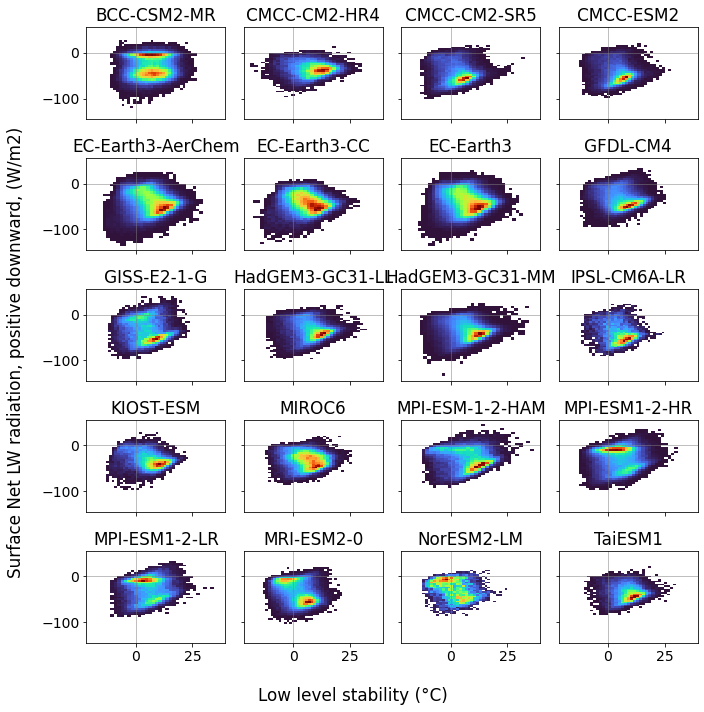

In [25]:
N = len(DF['Model'].unique())
fig, axs = plt.subplots(nrows=int(N/cols), ncols=cols, figsize=(10,10), sharex=True, sharey=True)
i=0
models = DF['Model'].unique()
for mod in models:
    plt_data = DF[DF['Model']==mod]
    plt_data = plt_data[['LLS', 'rlns']].dropna()
    sns.histplot(data=plt_data,
                x ='LLS', y='rlns',
                ax = axs.flatten()[i],
                cmap='turbo', bins=30)
    #            
    axs.flatten()[i].set_title(mod)
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    axs.flatten()[i].axhline(y=0, color='gray', lw=0.5)
    axs.flatten()[i].axvline(x=0, color='gray', lw=0.5)
    
    i=i+1
    
fig.supxlabel('Low level stability (°C)')
fig.supylabel('Surface Net LW radiation, positive downward, (W/m2)')
plt.tight_layout()
    #sns.histplot(ax = axs[i], data=DF[DF['Region']==region],
    #            x="LLS", hue="Model", bins=30)
    #i=i+1
plt.savefig('Figures/LLS_rlns_Hists.png', dpi=300)

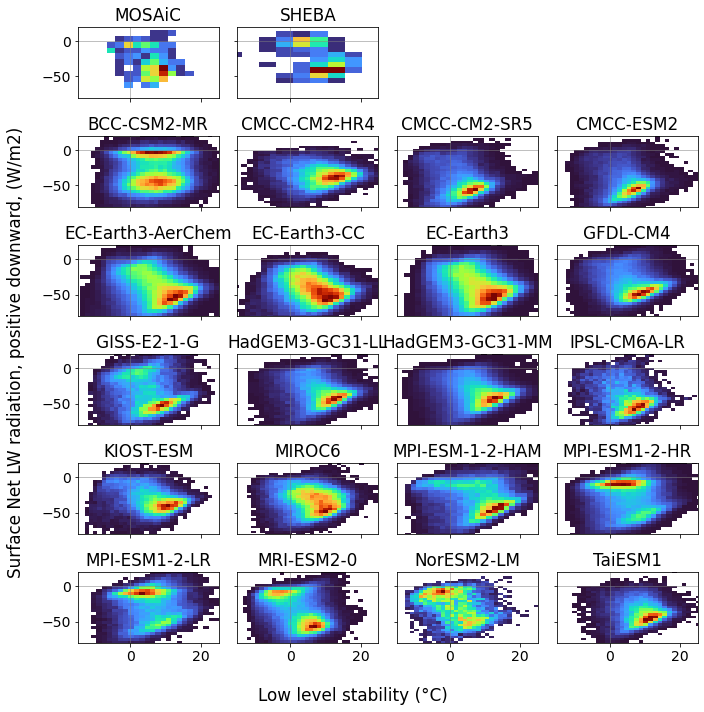

In [26]:
### repeat the rlns vs lls plot, with observations added
N = len(DF['Model'].unique())

fig, axs = plt.subplots(nrows=6, ncols=cols, figsize=(10,10), sharex=True, sharey=True)
xlims=[-15, 25]
ylims=[-80, 20]

i=0
camp='MOSAiC'
sns.histplot(data=DF_obs[DF_obs['Campaign']==camp],
                x ='low_level_stability', y='rlns',
                ax = axs.flatten()[i],
                cmap='turbo', bins=10)
axs.flatten()[i].set_title(camp)
axs.flatten()[i].set_xlabel('')
axs.flatten()[i].set_ylabel('')
axs.flatten()[i].axhline(y=0, color='gray', lw=0.5)
axs.flatten()[i].axvline(x=0, color='gray', lw=0.5)

i=1
camp='SHEBA'
sns.histplot(data=DF_obs[DF_obs['Campaign']==camp],
                x ='low_level_stability', y='rlns',
                ax = axs.flatten()[i],
                cmap='turbo', bins=10)
axs.flatten()[i].set_title(camp)
axs.flatten()[i].set_xlabel('')
axs.flatten()[i].set_ylabel('')
axs.flatten()[i].axhline(y=0, color='gray', lw=0.5)
axs.flatten()[i].axvline(x=0, color='gray', lw=0.5)



i=4
models = DF['Model'].unique()
for mod in models:
    plt_data = DF[DF['Model']==mod]
    plt_data = plt_data[['LLS', 'rlns']].dropna()
    sns.histplot(data=plt_data,
                x ='LLS', y='rlns',
                ax = axs.flatten()[i],
                cmap='turbo', bins=30)
    #            
    axs.flatten()[i].set_title(mod)
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    axs.flatten()[i].axhline(y=0, color='gray', lw=0.5)
    axs.flatten()[i].axvline(x=0, color='gray', lw=0.5)
    
    i=i+1

for ax in axs.flatten():
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
fig.supxlabel('Low level stability (°C)')
fig.supylabel('Surface Net LW radiation, positive downward, (W/m2)')
plt.tight_layout()
axs.flatten()[3].remove()
axs.flatten()[2].remove()
        

plt.savefig('Figures/LLS_rlns_Hists_obs.png', dpi=300)

/tmp/ipykernel_521/3045982001.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_C['Cloudy_TF'] = np.where(df_C['CLOUD_AMOUNT']> 5, 'Cloudy', 'Clear')


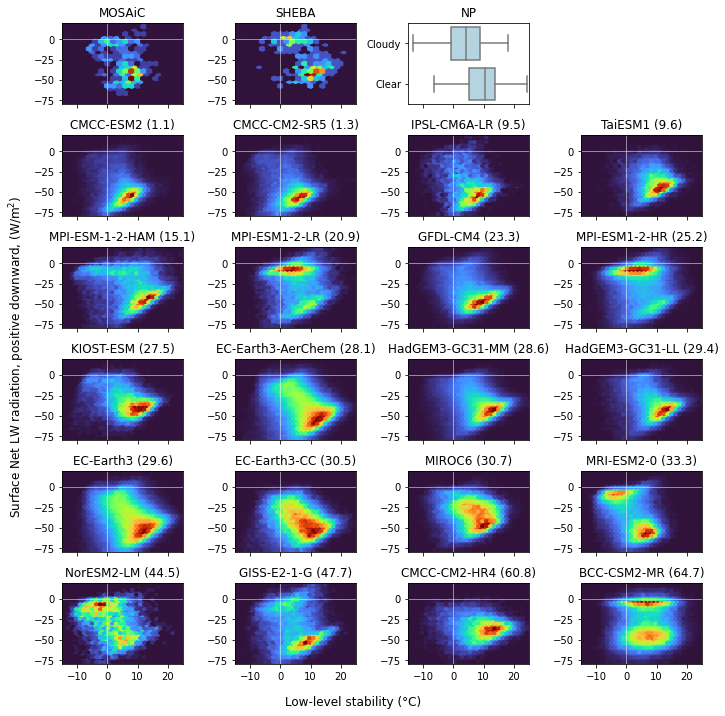

In [27]:
####### MAIN PLOT

### now hexbins
plt.rcParams.update({'font.size': 10})
N = len(DF['Model'].unique())
#cols=3
fig, axs = plt.subplots(nrows=6, ncols=cols, figsize=(10,10),
                        sharex=True, sharey=False)
xlims=[-15, 25]
ylims=[-80, 20]

i=0
camp='MOSAiC'
axs.flatten()[i].hexbin(data=DF_obs[DF_obs['Campaign']==camp],
                x ='low_level_stability', y='rlns',
                cmap='turbo', gridsize=20,
                extent=(xlims[0], xlims[1], ylims[0], ylims[1]))
axs.flatten()[i].set_title(camp)
axs.flatten()[i].set_xlabel('')
axs.flatten()[i].set_ylabel('')

i=1
camp='SHEBA'
axs.flatten()[i].hexbin(data=DF_obs[DF_obs['Campaign']==camp],
                x ='low_level_stability', y='rlns',
                cmap='turbo', gridsize=20,
                extent=(xlims[0], xlims[1], ylims[0], ylims[1]))
                    
axs.flatten()[i].set_title(camp)
axs.flatten()[i].set_xlabel('')
axs.flatten()[i].set_ylabel('')


i=2
camp='NP'
df_C = df_N[np.isin(df_N['CLOUD_AMOUNT_QLTY'],[0,1,4])]
df_C['Cloudy_TF'] = np.where(df_C['CLOUD_AMOUNT']> 5, 'Cloudy', 'Clear')
sns.boxplot(ax=axs.flatten()[i],
            data=df_C, x="low_level_stability",
            y="Cloudy_TF", orient='h', 
            order=['Cloudy','Clear'], color='lightblue')
axs.flatten()[i].set_title(camp) 
axs.flatten()[i].set_xlabel('')
axs.flatten()[i].set_ylabel('')
axs.flatten()[i].set_xlim(xlims)

i=4
models = DF['Model'].unique()

### import ordering list for models:
order_df = pd.read_csv('../Monthly_analysis/LLS_all_vars.csv')
order_df = order_df.sort_values('clwvi')
order_df = order_df[order_df['Model'].isin(models)]
mods = order_df['Model']
lab_dict = dict(zip(order_df['Model'], order_df['clwvi']))
lab_dict

for mod in mods:
    plt_data = DF[DF['Model']==mod]
    plt_data = plt_data[['LLS', 'rlns']].dropna()
    axs.flatten()[i].hexbin(data=plt_data,
                x ='LLS', y='rlns',
                cmap='turbo', gridsize=30,
                extent=(xlims[0], xlims[1], ylims[0], ylims[1]))
                            
    #            
    lab = mod+' ('+str("%.1f" % (1000*lab_dict[mod]))+')'
    axs.flatten()[i].set_title(lab)
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    
    
    i=i+1

for i in [0, 1]:
    ax = axs.flatten()[i]
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.axhline(y=0, color='white', lw=0.5)
    ax.axvline(x=0, color='white', lw=0.5)
    
for i in range(4, 24):
    ax = axs.flatten()[i]
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.axhline(y=0, color='white', lw=0.5)
    ax.axvline(x=0, color='white', lw=0.5)

fig.supxlabel('Low-level stability (°C)')
fig.supylabel('Surface Net LW radiation, positive downward, (W/$\mathregular{m^{2}}$)')

axs.flatten()[3].remove()

plt.tight_layout()
    #sns.histplot(ax = axs[i], data=DF[DF['Region']==region],
    #            x="LLS", hue="Model", bins=30)
    #i=i+1
plt.savefig('Figures/LLS_rlns_Hists_obs_hexs_no_mods_dropped.jpg', dpi=600)

/tmp/ipykernel_521/411603678.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_C['Cloudy_TF'] = np.where(df_C['CLOUD_AMOUNT']> 5, 'Cloudy', 'Clear')


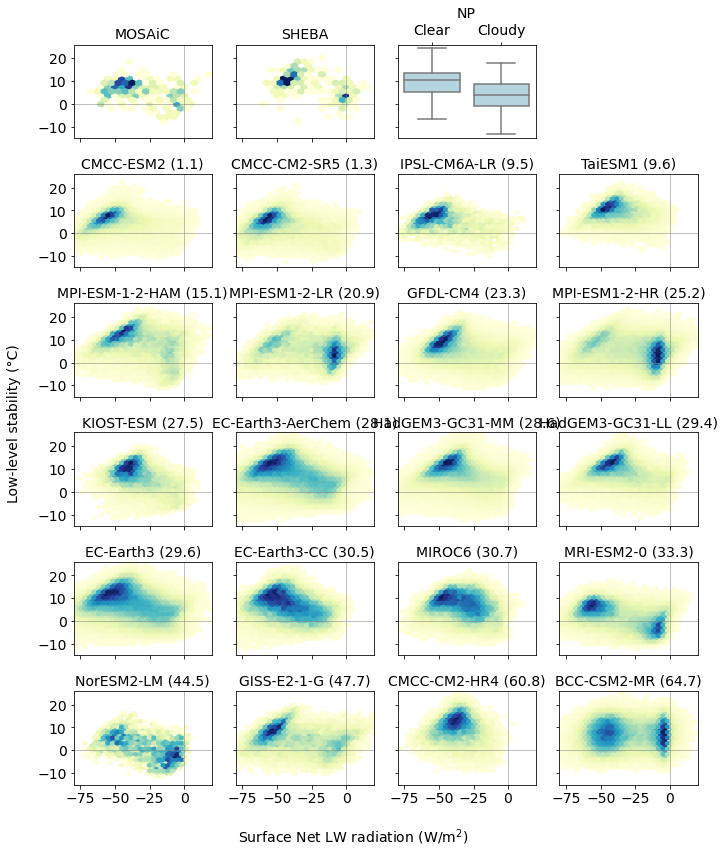

In [28]:
#### new version of figure 4, 18/03/2024. Add letter labels, reverse x-y axes, and redo colormap:

####### MAIN PLOT
colormap = 'RdPu'
colormap = 'YlGnBu'
### now hexbins
plt.rcParams.update({'font.size': 14})
N = len(DF['Model'].unique())
#cols=3
fig, axs = plt.subplots(nrows=6, ncols=cols, figsize=(10,12),
                        sharey=True, sharex=False)
ylims=[-15, 26]
xlims=[-80, 20]

i=0
camp='MOSAiC'
axs.flatten()[i].hexbin(data=DF_obs[DF_obs['Campaign']==camp],
                y ='low_level_stability', x='rlns',
                cmap=colormap, gridsize=20, mincnt=1,
                extent=(xlims[0], xlims[1], ylims[0], ylims[1]))
axs.flatten()[i].set_title(camp, fontsize='medium')
axs.flatten()[i].set_xlabel('')
axs.flatten()[i].set_ylabel('')

i=1
camp='SHEBA'
axs.flatten()[i].hexbin(data=DF_obs[DF_obs['Campaign']==camp],
                y ='low_level_stability', x='rlns',
                cmap=colormap, gridsize=20, mincnt=1,
                extent=(xlims[0], xlims[1], ylims[0], ylims[1]))
                    
axs.flatten()[i].set_title(camp, fontsize='medium')
axs.flatten()[i].set_xlabel('')
axs.flatten()[i].set_ylabel('')


i=2
camp='NP'
df_C = df_N[np.isin(df_N['CLOUD_AMOUNT_QLTY'],[0,1,4])]
df_C['Cloudy_TF'] = np.where(df_C['CLOUD_AMOUNT']> 5, 'Cloudy', 'Clear')
sns.boxplot(ax=axs.flatten()[i],
            data=df_C, y="low_level_stability",
            x="Cloudy_TF", orient='v', 
            order=['Clear', 'Cloudy'], color='lightblue')
axs.flatten()[i].set_title(camp, fontsize='medium') 
axs.flatten()[i].set_xlabel('')
axs.flatten()[i].set_ylabel('')
axs.flatten()[i].set_ylim(ylims)
axs.flatten()[i].xaxis.tick_top()

i=4
models = DF['Model'].unique()

### import ordering list for models:
order_df = pd.read_csv('../Monthly_analysis/LLS_all_vars.csv')
order_df = order_df.sort_values('clwvi')
order_df = order_df[order_df['Model'].isin(models)]
mods = order_df['Model']
lab_dict = dict(zip(order_df['Model'], order_df['clwvi']))
lab_dict

for mod in mods:
    plt_data = DF[DF['Model']==mod]
    plt_data = plt_data[['LLS', 'rlns']].dropna()
    axs.flatten()[i].hexbin(data=plt_data,
                y ='LLS', x='rlns',
                cmap=colormap, gridsize=30, mincnt=5,
                extent=(xlims[0], xlims[1], ylims[0], ylims[1]))
                            
    #            
    lab = mod+' ('+str("%.1f" % (1000*lab_dict[mod]))+')'
    axs.flatten()[i].set_title(lab, fontsize='medium')
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    
    i=i+1

for i in [0, 1]:
    ax = axs.flatten()[i]
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_yticks([-10, 0, 10, 20])
    ax.set_xticks([-75, -50, -25, 0])
    #ax.grid()
    ax.axvline(x=0, color='gray', lw=0.5)
    ax.axhline(y=0, color='gray', lw=0.5)
    
for i in range(4, 24):
    ax = axs.flatten()[i]
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_yticks([-10, 0, 10, 20])
    ax.set_xticks([-75, -50, -25, 0])
    ax.axvline(x=0, color='gray', lw=0.5)
    ax.axhline(y=0, color='gray', lw=0.5)

for i in range(0, 2):
    ax = axs.flatten()[i]
    ax.set_xticklabels([])
for i in range(4, 20):
    ax = axs.flatten()[i]
    ax.set_xticklabels([])
    
for i in range(20, 24):
    ax = axs.flatten()[i]
    ax.tick_params(axis='x', labelsize='medium')
    
fig.supylabel('Low-level stability (°C)', fontsize='medium')
fig.supxlabel('Surface Net LW radiation (W/$\mathregular{m^{2}}$)', fontsize='medium')

axs.flatten()[3].remove()

plt.tight_layout()
    #sns.histplot(ax = axs[i], data=DF[DF['Region']==region],
    #            x="LLS", hue="Model", bins=30)
    #i=i+1
#plt.savefig('Figures/LLS_rlns_Hists_obs_hexs_no_mods_dropped.jpg', dpi=600)



In [29]:
test_mods = ['BCC-CSM2-MR', 'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 'NorESM2-LM']
vals = []
for test_df in [DF[~DF['Model'].isin(test_mods)], DF[DF['Model'].isin(test_mods)]]:
    x = np.mean(test_df.groupby('Model')['tas'].mean().reset_index()['tas'])
    print(x)
    vals.append(x)
print(vals[1]-vals[0])

-25.38891971846456
-24.8256072429051
0.5633124755594601


In [30]:
test_mods = ['MPI-ESM1-2-LR', 'MPI-ESM1-2-HR']
vals = []
for test_df in [DF[DF['Model']=='MPI-ESM-1-2-HAM'], DF[DF['Model'].isin(test_mods)]]:
    x = np.mean(test_df.groupby('Model')['tas'].mean().reset_index()['tas'])
    print(x)
    vals.append(x)
print(vals[1]-vals[0])

-26.624404354559392
-25.804698376471983
0.8197059780874092


1.0


(array([7.200e+01, 7.520e+02, 3.327e+03, 8.206e+03, 7.683e+03, 4.210e+03,
        2.353e+03, 1.051e+03, 1.310e+02, 3.000e+00]),
 array([-83.71818  , -73.1433484, -62.5685168, -51.9936852, -41.4188536,
        -30.844022 , -20.2691904,  -9.6943588,   0.8804728,  11.4553044,
         22.030136 ]),
 <BarContainer object of 10 artists>)

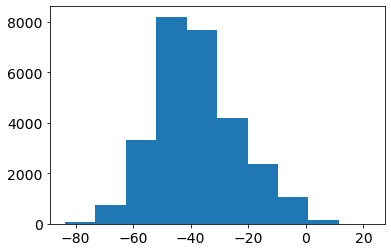

In [31]:
# test diptest
import diptest
plt_data = DF[DF['Model']=='TaiESM1']
x = plt_data[['rlns']].dropna()
x = x.sort_values(by='rlns')
dip, pval = diptest.diptest(x['rlns'], boot_pval=True, n_boot=100)
print(pval)
plt.hist(x['rlns'])

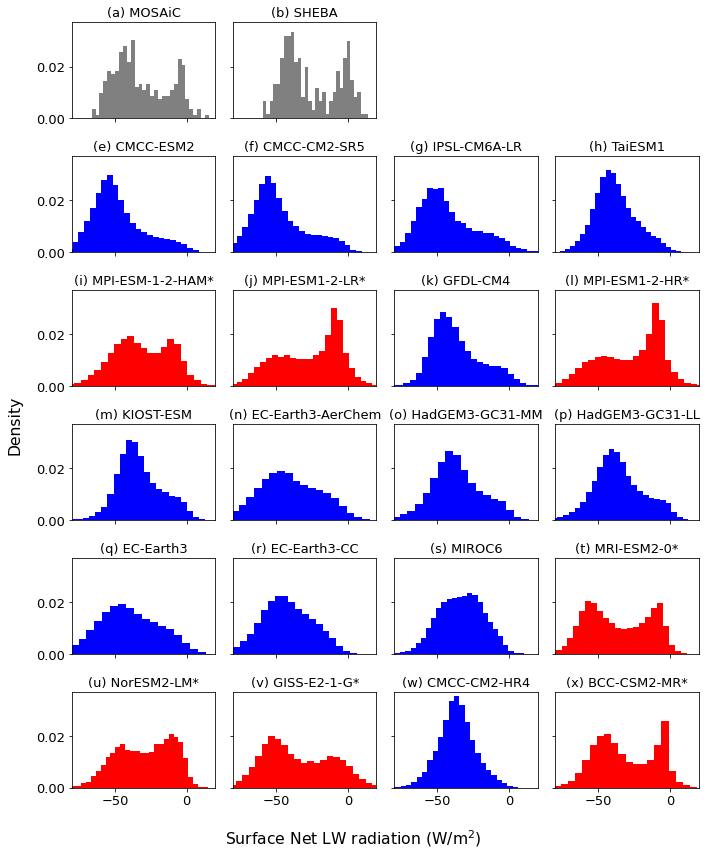

In [32]:
### add new main fig, with only 1d histograms, and starred models where DIP test passed

### now hexbins
plt.rcParams.update({'font.size': 13})
N = len(DF['Model'].unique())
#cols=
fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(10,12),
                        sharex=True, sharey=True)

xlims=[-80, 20]

i=0
camp='MOSAiC'
axs.flatten()[i].hist(DF_obs[DF_obs['Campaign']==camp]['rlns'],
                      bins=30, color='gray', density=True)

x = DF_obs[DF_obs['Campaign']==camp].sort_values(by='rlns')
dip, pval = diptest.diptest(x['rlns'], boot_pval=True, n_boot=100)

axs.flatten()[i].set_xlim(xlims)
#axs.flatten()[i].set_title(camp)
axs.flatten()[i].set_title(str('('+alphabet[i]+') '+camp), fontsize='medium')
axs.flatten()[i].set_xlabel('')
axs.flatten()[i].set_ylabel('')

i=1
camp='SHEBA'
axs.flatten()[i].hist(DF_obs[DF_obs['Campaign']==camp]['rlns'],
                      bins=30, color='gray', density=True)


x = DF_obs[DF_obs['Campaign']==camp].sort_values(by='rlns')
dip, pval = diptest.diptest(x['rlns'], boot_pval=True, n_boot=100)

axs.flatten()[i].set_xlim(xlims)
axs.flatten()[i].set_title(str('('+alphabet[i]+') '+camp), fontsize='medium')
axs.flatten()[i].set_xlabel('')
axs.flatten()[i].set_ylabel('')


i=2
camp='NP'


i=4
models = DF['Model'].unique()

### import ordering list for models:
order_df = pd.read_csv('../Monthly_analysis/LLS_all_vars.csv')
order_df = order_df.sort_values('clwvi')
order_df = order_df[order_df['Model'].isin(models)]
mods = order_df['Model']
lab_dict = dict(zip(order_df['Model'], order_df['clwvi']))
lab_dict

star_mods = []
stars = []
bimodal_mods = []

for mod in mods:
    plt_data = DF[DF['Model']==mod]
    plt_data = plt_data[['rlns']].dropna()

    x = plt_data.sort_values(by='rlns')
    dip, pval = diptest.diptest(x['rlns'], boot_pval=True, n_boot=100)
    star = ''
    col = 'blue'

    if pval < 0.05:
        star = '*'
        col = 'red'
        bimodal_mods.append(mod)
    lab = mod+star
    star_mods.append(mod)
    stars.append(star)
    
    axs.flatten()[i].hist(plt_data, bins=30, color=col, density=True)
    axs.flatten()[i].set_xlim(xlims)
    axs.flatten()[i].set_title(str('('+alphabet[i]+') '+lab), fontsize='medium')
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    i=i+1
    
stars_dict = dict(zip(star_mods, stars))

fig.supxlabel('Surface Net LW radiation (W/$\mathregular{m^{2}}$)')
fig.supylabel('Density')
plt.tight_layout()
axs.flatten()[2].remove()
axs.flatten()[3].remove()

plt.savefig('Figures/rlns_Hists_1d_obs_mods_dip_test_no_mods_dropped.jpg', dpi=600)


/tmp/ipykernel_521/2436469377.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_C['Cloudy_TF'] = np.where(df_C['CLOUD_AMOUNT']> 5, 'Cloudy', 'Clear')


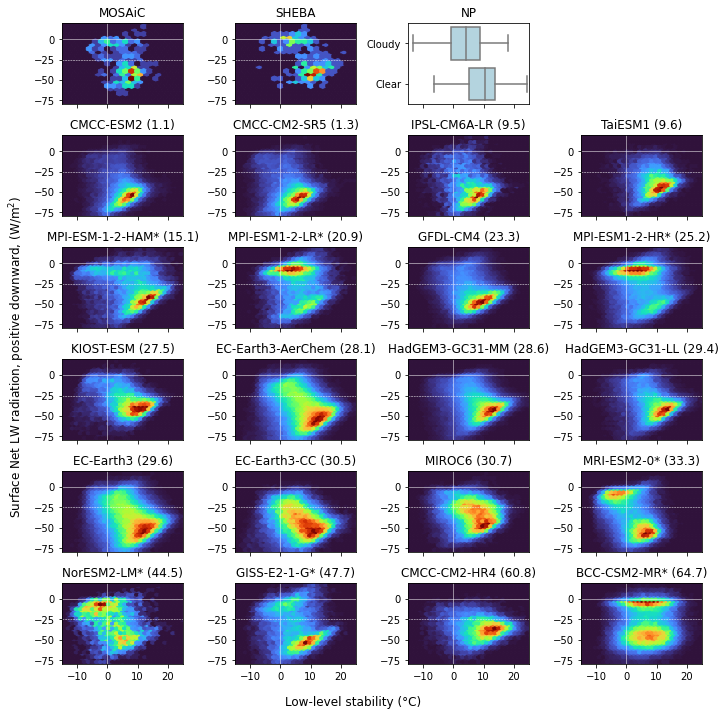

In [33]:
### repeat the main plot, now starring the bimodal models

### now hexbins
plt.rcParams.update({'font.size': 10})
N = len(DF['Model'].unique())
#cols=3
fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(10,10),
                        sharex=True, sharey=False)
xlims=[-15, 25]
ylims=[-80, 20]

i=0
camp='MOSAiC'
axs.flatten()[i].hexbin(data=DF_obs[DF_obs['Campaign']==camp],
                x ='low_level_stability', y='rlns',
                cmap='turbo', gridsize=20,
                extent=(xlims[0], xlims[1], ylims[0], ylims[1]))
axs.flatten()[i].set_title(camp)
axs.flatten()[i].set_xlabel('')
axs.flatten()[i].set_ylabel('')

i=1
camp='SHEBA'
axs.flatten()[i].hexbin(data=DF_obs[DF_obs['Campaign']==camp],
                x ='low_level_stability', y='rlns',
                cmap='turbo', gridsize=20,
                extent=(xlims[0], xlims[1], ylims[0], ylims[1]))
                    
axs.flatten()[i].set_title(camp)
axs.flatten()[i].set_xlabel('')
axs.flatten()[i].set_ylabel('')


i=2
camp='NP'
df_C = df_N[np.isin(df_N['CLOUD_AMOUNT_QLTY'],[0,1,4])]
df_C['Cloudy_TF'] = np.where(df_C['CLOUD_AMOUNT']> 5, 'Cloudy', 'Clear')
sns.boxplot(ax=axs.flatten()[i],
            data=df_C, x="low_level_stability",
            y="Cloudy_TF", orient='h', 
            order=['Cloudy','Clear'], color='lightblue')
axs.flatten()[i].set_title(camp) 
axs.flatten()[i].set_xlabel('')
axs.flatten()[i].set_ylabel('')
axs.flatten()[i].set_xlim(xlims)

i=4
models = DF['Model'].unique()

### import ordering list for models:
order_df = pd.read_csv('../Monthly_analysis/LLS_all_vars.csv')
order_df = order_df.sort_values('clwvi')
order_df = order_df[order_df['Model'].isin(models)]
mods = order_df['Model']
lab_dict = dict(zip(order_df['Model'], order_df['clwvi']))
lab_dict

for mod in mods:
    plt_data = DF[DF['Model']==mod]
    plt_data = plt_data[['LLS', 'rlns']].dropna()
    axs.flatten()[i].hexbin(data=plt_data,
                x ='LLS', y='rlns',
                cmap='turbo', gridsize=30,
                extent=(xlims[0], xlims[1], ylims[0], ylims[1]))
                            
    #            
    lab = mod+stars_dict[mod]+' ('+str("%.1f" % (1000*lab_dict[mod]))+')'
    axs.flatten()[i].set_title(lab)
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    
    
    i=i+1

for i in [0, 1]:
    ax = axs.flatten()[i]
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.axhline(y=0, color='white', lw=0.5)
    ax.axhline(y=-25, color='white', lw=0.5, ls='--')
    
    ax.axvline(x=0, color='white', lw=0.5)
    
for i in range(4, 24):
    ax = axs.flatten()[i]
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.axhline(y=0, color='white', lw=0.5)
    ax.axvline(x=0, color='white', lw=0.5)
    ax.axhline(y=-25, color='white', lw=0.5, ls='--')

axs.flatten()[3].remove()
fig.supxlabel('Low-level stability (°C)')
fig.supylabel('Surface Net LW radiation, positive downward, (W/$\mathregular{m^{2}}$)')
plt.tight_layout()
    #sns.histplot(ax = axs[i], data=DF[DF['Region']==region],
    #            x="LLS", hue="Model", bins=30)
    #i=i+1
plt.savefig('Figures/LLS_rlns_Hists_obs_hexs_starred_no_mods_dropped.jpg', dpi=600, bbox_inches='tight')


/tmp/ipykernel_521/3640363497.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_C['Cloudy_TF'] = np.where(df_C['CLOUD_AMOUNT']> 5, 'Cloudy', 'Clear')


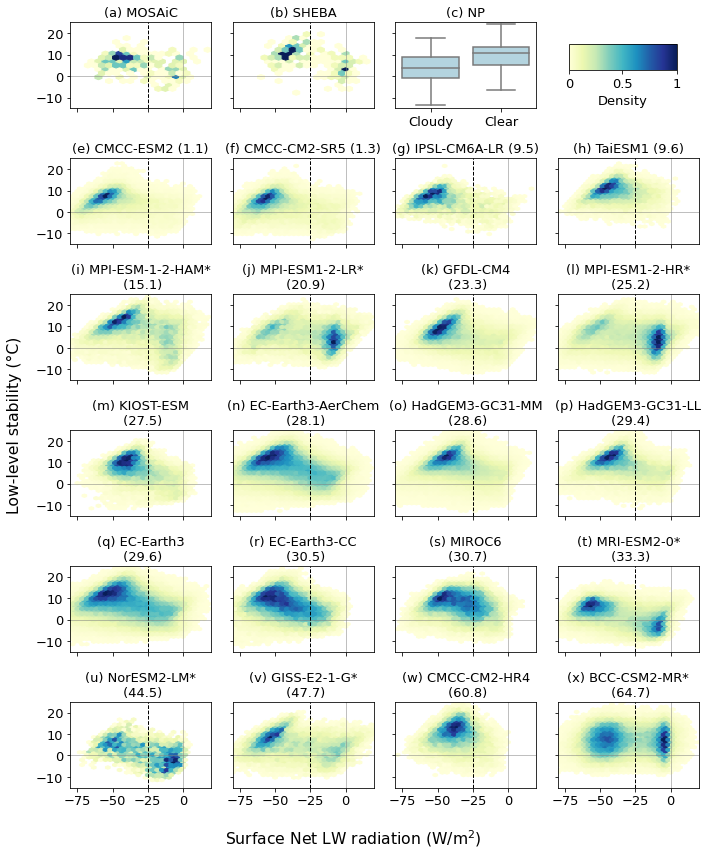

In [35]:
### repeat the main plot, now starring the bimodal models
colormap = 'YlGnBu'
### now hexbins
plt.rcParams.update({'font.size': 13})
N = len(DF['Model'].unique())
#cols=3
fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(10,12),
                        sharex=False, sharey=True)
ylims=[-15, 25]
xlims=[-80, 20]

i=0
camp='MOSAiC'
axs.flatten()[i].hexbin(data=DF_obs[DF_obs['Campaign']==camp],
                y ='low_level_stability', x='rlns',
                cmap=colormap, gridsize=20, mincnt = 1,
                extent=(xlims[0], xlims[1], ylims[0], ylims[1]))
axs.flatten()[i].set_title(str('('+alphabet[i]+')'+' '+camp), fontsize='medium')
axs.flatten()[i].set_xlabel('')
axs.flatten()[i].set_ylabel('')

i=1
camp='SHEBA'
axs.flatten()[i].hexbin(data=DF_obs[DF_obs['Campaign']==camp],
                y ='low_level_stability', x='rlns',
                cmap=colormap, gridsize=20, mincnt = 1,
                extent=(xlims[0], xlims[1], ylims[0], ylims[1]))
                    
axs.flatten()[i].set_title(str('('+alphabet[i]+')'+' '+camp), fontsize='medium')
axs.flatten()[i].set_xlabel('')
axs.flatten()[i].set_ylabel('')


i=2
camp='NP'
df_C = df_N[np.isin(df_N['CLOUD_AMOUNT_QLTY'],[0,1,4])]
df_C['Cloudy_TF'] = np.where(df_C['CLOUD_AMOUNT']> 5, 'Cloudy', 'Clear')
sns.boxplot(ax=axs.flatten()[i],
            data=df_C, y="low_level_stability",
            x="Cloudy_TF", orient='v', 
            order=['Cloudy','Clear'], color='lightblue')
axs.flatten()[i].set_title(str('('+alphabet[i]+')'+' '+camp), fontsize='medium') 
axs.flatten()[i].set_xlabel('')
axs.flatten()[i].set_ylabel('')
axs.flatten()[i].set_ylim(ylims)

i=4
models = DF['Model'].unique()

### import ordering list for models:
order_df = pd.read_csv('../Monthly_analysis/LLS_all_vars.csv')
order_df = order_df.sort_values('clwvi')
order_df = order_df[order_df['Model'].isin(models)]
mods = order_df['Model']
lab_dict = dict(zip(order_df['Model'], order_df['clwvi']))
lab_dict

for mod in mods:
    plt_data = DF[DF['Model']==mod]
    plt_data = plt_data[['LLS', 'rlns']].dropna()
    c = axs.flatten()[i].hexbin(data=plt_data,
                y ='LLS', x='rlns',
                cmap=colormap, gridsize=30, mincnt = 5,
                extent=(xlims[0], xlims[1], ylims[0], ylims[1]))
                            
    if i <= 7:
        lab = '('+alphabet[i]+') '+mod+stars_dict[mod]+' ('+str("%.1f" % (1000*lab_dict[mod]))+')'            
    if i > 7:
        lab = '('+alphabet[i]+') '+mod+stars_dict[mod]+'\n'+' ('+str("%.1f" % (1000*lab_dict[mod]))+')'
    axs.flatten()[i].set_title(lab, fontsize='medium')
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    
    
    i=i+1

for i in [0, 1]:
    ax = axs.flatten()[i]
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_yticks([-10, 0, 10, 20])
    ax.set_xticks([-75, -50, -25, 0])
    ax.axvline(x=0, color='gray', lw=0.5)
    #ax.axvline(x=-25, color='gray', lw=0.5, ls='--')
    ax.axvline(x=-25, color='black', lw=1, ls='--')
    ax.axhline(y=0, color='gray', lw=0.5)
    
for i in range(4, 24):
    ax = axs.flatten()[i]
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_yticks([-10, 0, 10, 20])
    ax.set_xticks([-75, -50, -25, 0])
    ax.axvline(x=0, color='gray', lw=0.5)
    ax.axhline(y=0, color='gray', lw=0.5)
    ax.axvline(x=-25, color='black', lw=1, ls='--')

axs.flatten()[3].remove()


for i in range(0, 2):
    ax = axs.flatten()[i]
    ax.set_xticklabels([])
for i in range(4, 20):
    ax = axs.flatten()[i]
    ax.set_xticklabels([])
    
for i in range(20, 24):
    ax = axs.flatten()[i]
    ax.tick_params(axis='x', labelsize='medium')
for i in range(0, 24):
    ax = axs.flatten()[i]
    ax.tick_params(axis='y', labelsize='medium')


fig.supylabel('Low-level stability (°C)', fontsize='large')
fig.supxlabel('Surface Net LW radiation (W/$\mathregular{m^{2}}$)', fontsize='large')
plt.tight_layout()
    #sns.histplot(ax = axs[i], data=DF[DF['Region']==region],
    #            x="LLS", hue="Model", bins=30)
    #i=i+1

### Add a colorbar
# Adjust the layout to make room for the colorbar on the right
#plt.subplots_adjust(right=0.8, hspace=0.4)
# Create a colorbar to the right of the subplots
#func = lambda x,pos: "{:g}".format(np.round(100*x/len(plt_data), 1))
func = lambda x,pos: "{:g}".format(x/np.max(c.get_array()))
fmt = matplotlib.ticker.FuncFormatter(func)
cax = fig.add_axes([0.80, 0.91, 0.15, 0.03])  # (left, bottom, width, height)
cbar = plt.colorbar(c, cax=cax, orientation='horizontal', 
                    format=fmt, label='Density',
                    ticks = [5, np.max(c.get_array())/2, np.max(c.get_array())])
cbar.ax.set_xticklabels(['0', '0.5', '1'])

plt.savefig('Figures/LLS_rlns_Hists_obs_hexs_V2_starred_no_mods_dropped.jpg', dpi=600, bbox_inches='tight')

In [36]:
for mod in ['MPI-ESM-1-2-HAM', 'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR']:
    print(np.mean(DF[DF['Model']==mod].dropna(subset='LLS')['LLS']))

7.658576416871623
5.687935553490443
4.976313574925518


In [37]:
### clustering on a cutoff calue of -20 W/m2:
cutoff = -25
for mod in bimodal_mods:
    print(mod)
    test_df = DF[DF['Model']==mod].dropna(subset='rlns')
    a = np.round(len(test_df[test_df['rlns']>cutoff])/len(test_df), 3)
    b = np.round(len(test_df[test_df['rlns']<cutoff])/len(test_df), 3)
    print(a)
    print(b)
    print(a+b)
    

for camp in ['MOSAiC', 'SHEBA']:
    print(camp)
    test_df = DF_obs[DF_obs['Campaign']==camp].dropna(subset='rlns')
    a = np.round(len(test_df[test_df['rlns']>cutoff])/len(test_df), 3)
    b = np.round(len(test_df[test_df['rlns']<cutoff])/len(test_df), 3)
    print(a)
    print(b)
    print(a+b)

MPI-ESM-1-2-HAM
0.403
0.597
1.0
MPI-ESM1-2-LR
0.535
0.465
1.0
MPI-ESM1-2-HR
0.543
0.457
1.0
MRI-ESM2-0
0.368
0.632
1.0
NorESM2-LM
0.469
0.531
1.0
GISS-E2-1-G
0.354
0.646
1.0
BCC-CSM2-MR
0.396
0.604
1.0
MOSAiC
0.348
0.652
1.0
SHEBA
0.413
0.587
1.0


### Finally, examine the wind suppression of LLS

MOSAiC -0.55 0.1 0.00
SHEBA -0.67 0.11 0.00
NP -0.63 0.11 0.00
12


/tmp/ipykernel_521/3033190869.py:126: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(bottom=0.1, right=0.68, top=0.9)


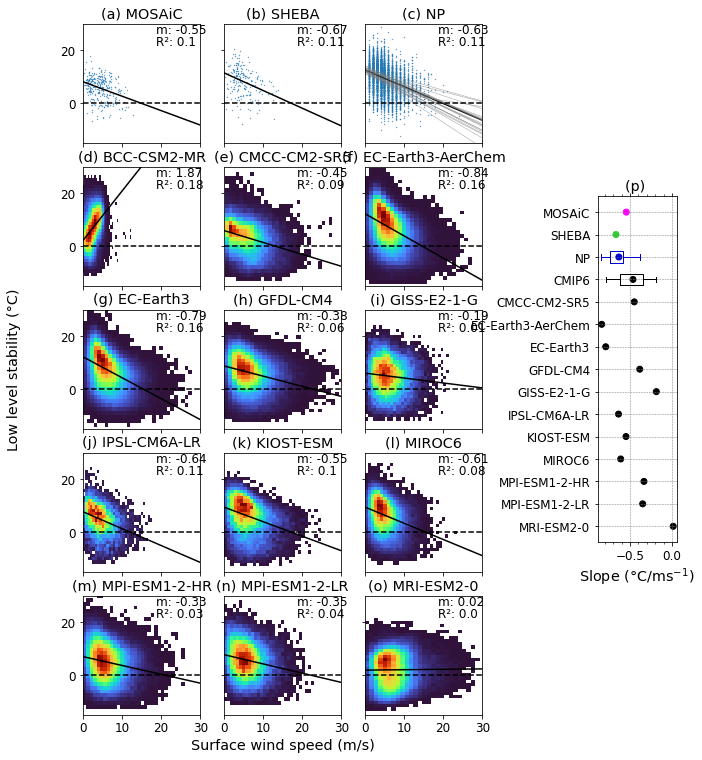

In [42]:
plt.rcParams.update({'font.size': 12})


var_x, var_y = 'wind_speed_surface', 'LLS'
xtxt=0.62
ytxt=0.85
xlims = [0, 30]
ylims = [-15, 30]

fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(10,12),
                        sharex=True, sharey=True,
                        layout="constrained")

labs = ['(a) ', '(b) ', '(c) ', '(d) ', '(e) ', '(f) ', '(g) ', '(h) ', '(i) ', '(j) ', '(k) ', 
        '(l) ', '(m) ', '(n) ', '(o) ', '(p) ', '(q) ']
i=0
camps=[]
slopes_obs=[]
slopes_camps=[]
intercepts_obs=[]
slopes_NP = []
for campaign in Campaigns:
    plt_data = DF_obs[DF_obs['Campaign']==campaign]
    plt_data = plt_data[['surf_wind_velocity', 'low_level_stability']].dropna()
    plt_data = plt_data[plt_data['surf_wind_velocity']>0]
    axs.flatten()[i].scatter(x =plt_data['surf_wind_velocity'], y=plt_data['low_level_stability'], s=0.1)
    regression = stats.linregress(x=plt_data['surf_wind_velocity'].astype(float), y=plt_data['low_level_stability'].astype(float))
    r2 = np.round((regression.rvalue)**2, 2)
    slope = str("%.2f" % regression.slope)
    slopes_camps.append(regression.slope)
    #pval = np.round(regression.pvalue, 3)
    pval = str("%.2f" % regression.pvalue)
    print(campaign, slope, r2, pval)
    xs= np.arange(xlims[0], xlims[1], 0.1)
    ys = (regression.slope*xs)+regression.intercept
    axs.flatten()[i].plot(xs, ys, c='black')
    axs.flatten()[i].set_title(labs[i]+campaign)
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    axs.flatten()[i].text(xtxt, ytxt, 'R\u00b2: '+str(r2), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    axs.flatten()[i].text(xtxt, ytxt+0.1, 'm: '+str(slope), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    #axs.flatten()[i].text(xtxt, ytxt-0.1, 'P-value: '+str(pval), horizontalalignment='left',
    # verticalalignment='center', transform=axs.flatten()[i].transAxes)
    #            
    if campaign == 'NP':
        for station in DF_obs[DF_obs['Campaign']=='NP']['station'].unique():
            camps.append(campaign+'_'+str(station))
            plt_data = DF_obs[DF_obs['station']==station]
            plt_data = plt_data[['surf_wind_velocity', 'low_level_stability']].dropna()
            plt_data = plt_data[plt_data['surf_wind_velocity']>0]
            regression = stats.linregress(x=plt_data['surf_wind_velocity'].astype(float), y=plt_data['low_level_stability'].astype(float))
            r2 = np.round((regression.rvalue)**2, 2)
            slope = str("%.2f" % regression.slope)
            pval = str("%.2f" % regression.pvalue)
            slopes_obs.append(regression.slope)
            slopes_NP.append(regression.slope)
            intercepts_obs.append(regression.intercept)
            xs= np.arange(xlims[0], xlims[1], 0.1)
            ys = (regression.slope*xs)+regression.intercept
            axs.flatten()[i].plot(xs, ys, c='gray', lw=0.5, alpha=0.75)
    else:
        camps.append(campaign)
        slopes_obs.append(regression.slope)

    i=i+1
df_obs_suppressions = pd.DataFrame({'Campaign':camps, 'LLS Suppression (°C/(m/s))': slopes_obs})


i=3
DF_wind = DF[[var_x, var_y, 'Model']].dropna()
models = DF_wind['Model'].unique()
print(len(models))
slopes_models=[]
intercepts_models = []

mod_wind_means = []
mod_lls_means = []

mods_for_plot = []
slopes_models_for_plot = []

for mod in models:
    plt_data = DF_wind[DF_wind['Model']==mod]
    plt_data = plt_data[[var_x, var_y]].dropna()
    sns.histplot(data=plt_data,
                x =var_x, y=var_y,
                ax = axs.flatten()[i],
                cmap='turbo', bins=30)
    regression = stats.linregress(x=plt_data[var_x].astype(float), y=plt_data[var_y].astype(float))
    r2 = np.round((regression.rvalue)**2, 2)
    slope = str("%.2f" % regression.slope)
    pval = str("%.2f" % regression.pvalue)
    if not mod == 'BCC-CSM2-MR':
        mods_for_plot.append(mod)
        slopes_models_for_plot.append(regression.slope)
    slopes_models.append(regression.slope)
    intercepts_models.append(regression.intercept)
    mod_wind_means.append(np.mean(plt_data[var_x].astype(float)))
    mod_lls_means.append(np.mean(plt_data[var_y].astype(float)))
    xs= np.arange(xlims[0], xlims[1], 0.1)
    ys = (regression.slope*xs)+regression.intercept
    axs.flatten()[i].plot(xs, ys, c='black')
    #            
    axs.flatten()[i].set_title(labs[i]+mod)
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    axs.flatten()[i].text(xtxt, ytxt, 'R\u00b2: '+str(r2), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    axs.flatten()[i].text(xtxt, ytxt+0.1, 'm: '+str(slope), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    #axs.flatten()[i].text(xtxt, ytxt-0.1, 'P-value: '+str(pval), horizontalalignment='left',
    # verticalalignment='center', transform=axs.flatten()[i].transAxes)
    
    i=i+1

df_mod_suppressions = pd.DataFrame({'Model':models, 'LLS Suppression (°C/(m/s))': slopes_models})
for ax in axs.flatten():
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.axhline(0, ls='--', color='black')

#plt.constrained_layout()

plt.subplots_adjust(bottom=0.1, right=0.68, top=0.9)
cax = plt.axes((0.84, 0.3, 0.11, 0.4))


slopes = np.concatenate(([slopes_camps, [np.mean(slopes_models_for_plot)], slopes_models_for_plot]))
labels = np.concatenate(([['MOSAiC', 'SHEBA', 'NP'], ['CMIP6'], mods_for_plot]))

cax.boxplot(slopes_models_for_plot,positions=[len(mods_for_plot)],widths=0.5,
           showmeans=False,
           whis=[5, 95], showfliers=False,
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':8,
                      'markerfacecolor':'black',
                      'markeredgecolor':'black'},
          vert=False)

bpNP = cax.boxplot(slopes_NP,positions=[len(mods_for_plot)+1],widths=0.5,
           showmeans=False,
           whis=[5, 95], showfliers=False,
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':8,
                      'markerfacecolor':'black',
                      'markeredgecolor':'black'},
          vert=False)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bpNP[element], color=colors['NP'])
#for box in bpNP['boxes']:
#    box.set(color=colors['NP'])

scatter_colors_obs = [colors[campaign] for campaign in ['NP', 'SHEBA', 'MOSAiC']]
scatter_colors_mm_mean = ['black']
scatter_colors_mods = ['black' for i in mods_for_plot]
scatter_colors =  scatter_colors_mods + scatter_colors_mm_mean + scatter_colors_obs 

cax.scatter(np.flip(slopes), np.flip(labels), c=scatter_colors)
cax.set_xlabel('Slope (°C/ms$^{-1}$)',fontsize='large')
#cax.set_xlim([-0.7, -0.3])
cax.tick_params(axis="x",direction="out", which='both', top=True, labeltop=False, bottom=True, labelbottom=True)
cax.xaxis.set_minor_locator(AutoMinorLocator())
cax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

cax.set_yticks(np.arange(len(labels)))
cax.set_yticklabels(np.flip(labels),rotation=0, fontsize='medium') 
cax.set_title(labs[i])
axs.flatten()[13].set_xlabel('Surface wind speed (m/s)', fontsize='large')
#fig.supxlabel('surface wind speed (m/s)')
fig.supylabel('Low level stability (°C)', fontsize='large')
#plt.tight_layout()
    #sns.histplot(ax = axs[i], data=DF[DF['Region']==region],
    #            x="LLS", hue="Model", bins=30)
    #i=i+1
plt.savefig('Figures/LLS_Surf_wind_speed_Hists_regs_no_mods_dropped.jpg', dpi=600)

MOSAiC -0.55 0.1 0.00000
SHEBA -0.67 0.11 0.00000
NP -0.63 0.11 0.00000
12


/tmp/ipykernel_521/1663439067.py:138: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


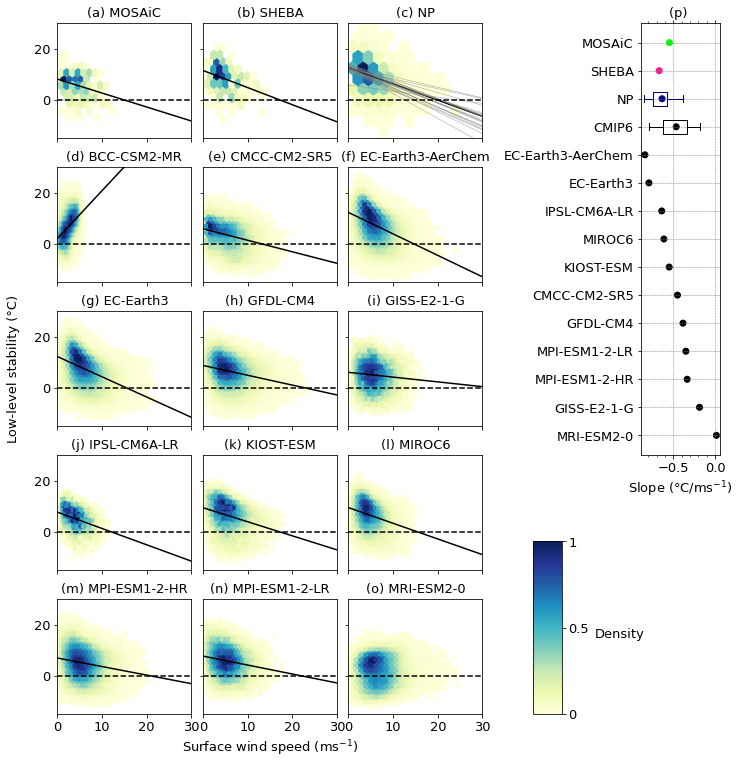

In [51]:
plt.rcParams.update({'font.size': 13})

colormap = 'YlGnBu'

var_x, var_y = 'wind_speed_surface', 'LLS'
xtxt=0.62
ytxt=0.85
xlims = [0, 30]
ylims = [-15, 30]

fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(10,12),
                        sharex=True, sharey=True,
                        layout="constrained")

labs = ['(a) ', '(b) ', '(c) ', '(d) ', '(e) ', '(f) ', '(g) ', '(h) ', '(i) ', '(j) ', '(k) ', 
        '(l) ', '(m) ', '(n) ', '(o) ', '(p) ', '(q) ']
i=0
camps=[]
slopes_obs=[]
slopes_camps=[]
intercepts_obs=[]
slopes_NP = []
for campaign in Campaigns:
    plt_data = DF_obs[DF_obs['Campaign']==campaign]
    plt_data = plt_data[['surf_wind_velocity', 'low_level_stability']].dropna()
    plt_data = plt_data[plt_data['surf_wind_velocity']>0]
    hist_data = plt_data[(plt_data['surf_wind_velocity']<xlims[1]) & (plt_data['low_level_stability']<ylims[1]) & (plt_data['low_level_stability']>ylims[0])]
    #sns.histplot(data=hist_data,
    #            x =hist_data['surf_wind_velocity'], y=hist_data['low_level_stability'],
     #           ax = axs.flatten()[i],
     #           cmap=colormap, bins=10)

    hist = axs.flatten()[i].hexbin(data=hist_data,
                x='surf_wind_velocity', y='low_level_stability',
               cmap=colormap, gridsize=10, mincnt = 1
               )
    
    #axs.flatten()[i].scatter(x =plt_data['surf_wind_velocity'], y=plt_data['low_level_stability'], s=0.1)
    regression = stats.linregress(x=plt_data['surf_wind_velocity'].astype(float), y=plt_data['low_level_stability'].astype(float))
    r2 = np.round((regression.rvalue)**2, 2)
    slope = str("%.2f" % regression.slope)
    slopes_camps.append(regression.slope)
    #pval = np.round(regression.pvalue, 3)
    pval = str("%.5f" % regression.pvalue)
    print(campaign, slope, r2, pval)
    xs= np.arange(xlims[0], xlims[1], 0.1)
    ys = (regression.slope*xs)+regression.intercept
    if regression.pvalue <0.001:
        axs.flatten()[i].plot(xs, ys, c='black')
    axs.flatten()[i].set_title(labs[i]+campaign, fontsize='medium')
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    #axs.flatten()[i].text(xtxt, ytxt, 'R\u00b2: '+str(r2), horizontalalignment='left',
    # verticalalignment='center', transform=axs.flatten()[i].transAxes)
    #axs.flatten()[i].text(xtxt, ytxt+0.1, 'm: '+str(slope), horizontalalignment='left',
    # verticalalignment='center', transform=axs.flatten()[i].transAxes)
    #axs.flatten()[i].text(xtxt, ytxt-0.1, 'P-value: '+str(pval), horizontalalignment='left',
    # verticalalignment='center', transform=axs.flatten()[i].transAxes)
    #            
    if campaign == 'NP':
        for station in DF_obs[DF_obs['Campaign']=='NP']['station'].unique():
            camps.append(campaign+'_'+str(station))
            plt_data = DF_obs[DF_obs['station']==station]
            plt_data = plt_data[['surf_wind_velocity', 'low_level_stability']].dropna()
            plt_data = plt_data[plt_data['surf_wind_velocity']>0]
            regression = stats.linregress(x=plt_data['surf_wind_velocity'].astype(float), y=plt_data['low_level_stability'].astype(float))
            r2 = np.round((regression.rvalue)**2, 2)
            slope = str("%.2f" % regression.slope)
            pval = str("%.2f" % regression.pvalue)
            slopes_obs.append(regression.slope)
            slopes_NP.append(regression.slope)
            intercepts_obs.append(regression.intercept)
            xs= np.arange(xlims[0], xlims[1], 0.1)
            ys = (regression.slope*xs)+regression.intercept
            axs.flatten()[i].plot(xs, ys, c='gray', lw=0.5, alpha=0.75)
    else:
        camps.append(campaign)
        slopes_obs.append(regression.slope)

    i=i+1
df_obs_suppressions = pd.DataFrame({'Campaign':camps, 'LLS Suppression (°C/(m/s))': slopes_obs})


i=3
DF_wind = DF[[var_x, var_y, 'Model']].dropna()
models = DF_wind['Model'].unique()
print(len(models))
slopes_models=[]
intercepts_models = []

mod_wind_means = []
mod_lls_means = []

mods_for_plot = []
slopes_models_for_plot = []

for mod in models:
    plt_data = DF_wind[DF_wind['Model']==mod]
    plt_data = plt_data[[var_x, var_y]].dropna()
    #hist = sns.histplot(data=plt_data,
    #           x =var_x, y=var_y,
    #            ax = axs.flatten()[i],
    #            cmap=colormap, bins=30)

    hist = axs.flatten()[i].hexbin(data=plt_data,
                x =var_x, y=var_y,
                cmap=colormap, gridsize=30, mincnt = 5,
                )
    regression = stats.linregress(x=plt_data[var_x].astype(float), y=plt_data[var_y].astype(float))
    r2 = np.round((regression.rvalue)**2, 2)
    slope = str("%.2f" % regression.slope)
    pval = str("%.2f" % regression.pvalue)
    if not mod == 'BCC-CSM2-MR':
        mods_for_plot.append(mod)
        slopes_models_for_plot.append(regression.slope)
    slopes_models.append(regression.slope)
    intercepts_models.append(regression.intercept)
    mod_wind_means.append(np.mean(plt_data[var_x].astype(float)))
    mod_lls_means.append(np.mean(plt_data[var_y].astype(float)))
    if regression.pvalue < 0.001:
    #if r2 > 0.1:
        xs= np.arange(xlims[0], xlims[1], 0.1)
        ys = (regression.slope*xs)+regression.intercept
        axs.flatten()[i].plot(xs, ys, c='black')
    #            
    axs.flatten()[i].set_title(labs[i]+mod, fontsize='medium')
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    #axs.flatten()[i].text(xtxt, ytxt, 'R\u00b2: '+str(r2), horizontalalignment='left',
    # verticalalignment='center', transform=axs.flatten()[i].transAxes)
    #axs.flatten()[i].text(xtxt, ytxt+0.1, 'm: '+str(slope), horizontalalignment='left',
    # verticalalignment='center', transform=axs.flatten()[i].transAxes)
    #axs.flatten()[i].text(xtxt, ytxt-0.1, 'P-value: '+str(pval), horizontalalignment='left',
    # verticalalignment='center', transform=axs.flatten()[i].transAxes)
    
    i=i+1
fig.supylabel('Low-level stability (°C)', fontsize='medium')
plt.tight_layout()

df_mod_suppressions = pd.DataFrame({'Model':models, 'LLS Suppression (°C/(m/s))': slopes_models})
for ax in axs.flatten():
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.axhline(0, ls='--', color='black')

#plt.constrained_layout()

plt.subplots_adjust(bottom=0.1, right=0.68, top=0.9)
#cax = plt.axes((0.84, 0.3, 0.11, 0.4))
cax = plt.axes((0.9, 0.4, 0.11, 0.5))

DF_TEMP = pd.DataFrame({'Model':mods_for_plot,
                        'Slope':slopes_models_for_plot})
DF_TEMP = DF_TEMP.sort_values('Slope')
slopes = np.concatenate(([slopes_camps, [np.mean(slopes_models_for_plot)], DF_TEMP['Slope']]))
labels = np.concatenate(([['MOSAiC', 'SHEBA', 'NP'], ['CMIP6'], DF_TEMP['Model']]))

cax.boxplot(slopes_models_for_plot,positions=[len(mods_for_plot)],widths=0.5,
           showmeans=False,
           whis=[5, 95], showfliers=False,
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':8,
                      'markerfacecolor':'black',
                      'markeredgecolor':'black'},
          vert=False)

bpNP = cax.boxplot(slopes_NP,positions=[len(mods_for_plot)+1],widths=0.5,
           showmeans=False,
           whis=[5, 95], showfliers=False,
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':8,
                      'markerfacecolor':'black',
                      'markeredgecolor':'black'},
          vert=False)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bpNP[element], color=colors['NP'])
#for box in bpNP['boxes']:
#    box.set(color=colors['NP'])

scatter_colors_obs = [colors[campaign] for campaign in ['NP', 'SHEBA', 'MOSAiC']]
scatter_colors_mm_mean = ['black']
scatter_colors_mods = ['black' for i in mods_for_plot]
scatter_colors =  scatter_colors_mods + scatter_colors_mm_mean + scatter_colors_obs 

cax.scatter(np.flip(slopes), np.flip(labels), c=scatter_colors)
cax.set_xlabel('Slope (°C/ms$^{-1}$)', fontsize='medium')
#cax.set_xlim([-0.7, -0.3])
cax.tick_params(axis="x",direction="out", which='both', top=True, labeltop=False, bottom=True, labelbottom=True)
cax.xaxis.set_minor_locator(AutoMinorLocator())
cax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

cax.set_yticks(np.arange(len(labels)))
cax.set_yticklabels(np.flip(labels),rotation=0, fontsize='medium') 
cax.set_title(labs[i], fontsize='medium')
axs.flatten()[13].set_xlabel('Surface wind speed (ms$^{-1}$)', fontsize='medium')
#fig.supxlabel('surface wind speed (m/s)')
    #sns.histplot(ax = axs[i], data=DF[DF['Region']==region],
    #            x="LLS", hue="Model", bins=30)
    #i=i+1


#func = lambda x,pos: "{:g}".format(np.round(50*x/len(plt_data), 1))
func = lambda x,pos: "{:g}".format(x/np.max(hist.get_array()))
fmt = matplotlib.ticker.FuncFormatter(func)
ccax = fig.add_axes([0.75, 0.1, 0.04, 0.2])  # (left, bottom, width, height)
cb = fig.colorbar(hist, cax=ccax, orientation='vertical', format=fmt, 
                  ticks=[5, np.max(hist.get_array())/2, np.max(hist.get_array())])
cb.set_label('Density', loc='center', rotation=0, labelpad=30)
cb.ax.set_yticklabels(['0', '0.5', '1'])

plt.savefig('Figures/LLS_Surf_wind_speed_Hists_regs_no_mods_dropped_obs_hists.jpg', dpi=600, bbox_inches='tight')

In [44]:
s = DF_obs[DF_obs['Campaign']=='SHEBA']
s = s[s['surf_wind_velocity']>0]
p = np.percentile(s['surf_wind_velocity'], 90)
m = DF_obs[DF_obs['Campaign']=='MOSAiC']
m = m[m['surf_wind_velocity']>0]
n = DF_obs[DF_obs['Campaign']=='NP']
n = n[n['surf_wind_velocity']>0]
ms = m[m['surf_wind_velocity']>p]
print(len(m), len(ms))

302 24


In [45]:
for d in [m, s, n]:
    print(np.max(d['surf_wind_velocity']))
    print(len(d[d['surf_wind_velocity']>25])/len(d))

12.85203667761371
0.0
13.94
0.0
37.0
0.001366535074400243


(array([28., 65., 40., 61., 44., 29., 14., 13.,  6.,  2.]),
 array([ 0.16557726,  1.4342232 ,  2.70286914,  3.97151508,  5.24016103,
         6.50880697,  7.77745291,  9.04609885, 10.31474479, 11.58339074,
        12.85203668]),
 <BarContainer object of 10 artists>)

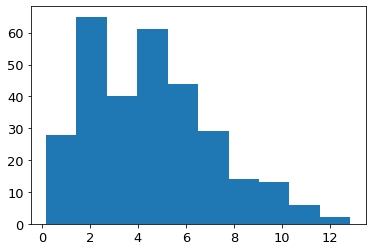

In [46]:
plt.hist(m['surf_wind_velocity'])

(array([13., 36., 59., 29., 27., 13., 12.,  2.,  5.,  4.]),
 array([ 0.38 ,  1.736,  3.092,  4.448,  5.804,  7.16 ,  8.516,  9.872,
        11.228, 12.584, 13.94 ]),
 <BarContainer object of 10 artists>)

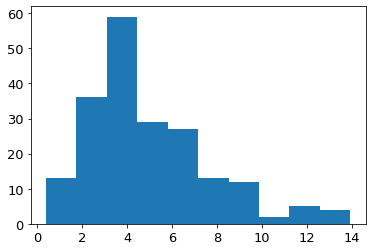

In [47]:
plt.hist(s['surf_wind_velocity'])

(array([3.276e+03, 2.430e+03, 5.540e+02, 2.290e+02, 5.700e+01, 2.200e+01,
        1.000e+01, 5.000e+00, 1.000e+00, 2.000e+00]),
 array([ 1. ,  4.6,  8.2, 11.8, 15.4, 19. , 22.6, 26.2, 29.8, 33.4, 37. ]),
 <BarContainer object of 10 artists>)

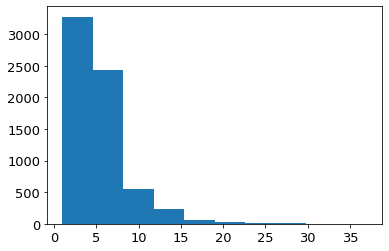

In [48]:
plt.hist(n['surf_wind_velocity'])

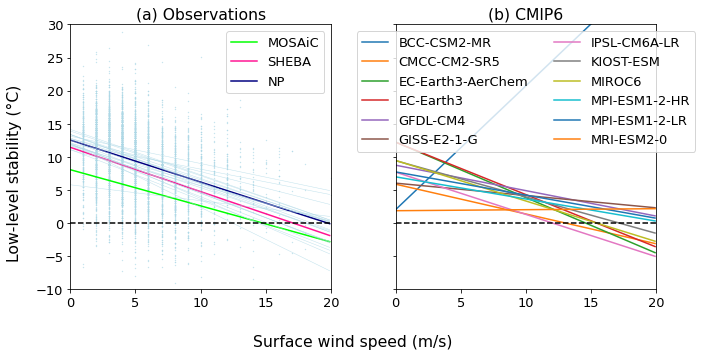

In [49]:

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharex=True, sharey=True)
xlims = [0, 20]
ylims = [-10, 30]

colors = {'NP': 'navy', 'SHEBA': 'deeppink', 'MOSAiC': 'lime'}
pvals_obs = []
ax = axs.flatten()[0]
for campaign in Campaigns:
    plt_data = DF_obs[DF_obs['Campaign']==campaign]
    plt_data = plt_data[['surf_wind_velocity', 'low_level_stability']].dropna()
    plt_data = plt_data[plt_data['surf_wind_velocity']>0]
    if campaign == 'NP':
        ax.scatter(x =plt_data['surf_wind_velocity'], y=plt_data['low_level_stability'],
                   color='lightblue', s=0.1)
    regression = stats.linregress(x=plt_data['surf_wind_velocity'].astype(float), y=plt_data['low_level_stability'].astype(float))
    r2 = np.round((regression.rvalue)**2, 2)
    slope = np.round(regression.slope, 2)
    pval = np.round(regression.pvalue, 3)
    pvals_obs.append(pval)
    xs= np.arange(xlims[0], xlims[1], 0.1)
    ys = (regression.slope*xs)+regression.intercept
    ax.plot(xs, ys, color=colors[campaign], label=campaign)
    ax.set_xlabel('')
    ax.set_ylabel('')
ax.legend(ncol=1, loc="upper right", fontsize='medium')
ax.set_title('(a) Observations')
#            
for station in DF_obs[DF_obs['Campaign']=='NP']['station'].unique():
    camps.append(campaign+'_'+str(station))
    plt_data = DF_obs[DF_obs['station']==station]
    plt_data = plt_data[['surf_wind_velocity', 'low_level_stability']].dropna()
    plt_data = plt_data[plt_data['surf_wind_velocity']>0]
    regression = stats.linregress(x=plt_data['surf_wind_velocity'].astype(float), y=plt_data['low_level_stability'].astype(float))
    r2 = np.round((regression.rvalue)**2, 2)
    slope = np.round(regression.slope, 2)
    pval = np.round(regression.pvalue, 3)
    #slopes_obs.append(regression.slope)
    intercepts_obs.append(regression.intercept)
    xs= np.arange(xlims[0], xlims[1], 0.1)
    ys = (regression.slope*xs)+regression.intercept
    ax.plot(xs, ys, c='lightblue', lw=0.5, alpha=0.75)

ax = axs.flatten()[1]

for i in range(len(slopes_models)):
    slope = slopes_models[i]
    intercept = intercepts_models[i]
    xs= np.arange(xlims[0], xlims[1], 0.1)
    ys = (slope*xs)+intercept
    ax.plot(xs, ys, label=models[i])


ax.legend(ncol=2, loc="upper center", fontsize='medium')

ax.set_title('(b) CMIP6')
"""
slope_m = np.mean(slopes_models)
int_m = np.mean(intercepts_models)
xs= np.arange(xlims[0], xlims[1], 0.1)
ys = (slope_m*xs)+int_m
ax.plot(xs, ys, c='black')
"""

for ax in axs.flatten():
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.axhline(0, ls='--', color='black')
    
fig.supxlabel('Surface wind speed (m/s)')
fig.supylabel('Low-level stability (°C)')
plt.tight_layout()
plt.savefig('Figures/Wind_suppression_of_LLS_summary.png', dpi=450)
#print()

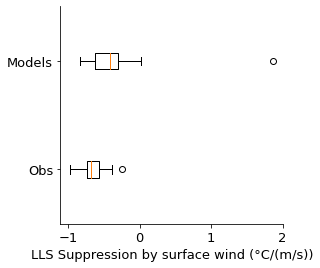

In [50]:
fig, ax = plt.subplots(figsize=(4,4))


#sns.kdeplot(ax=ax, data=df_obs_suppressions, x='LLS Suppression (°C/(m/s))', color='blue', label='Observations')
#sns.kdeplot(ax=ax, data=df_mod_suppressions, x='LLS Suppression (°C/(m/s))', color='red', label='Models')
ax.boxplot([df_obs_suppressions['LLS Suppression (°C/(m/s))'], df_mod_suppressions['LLS Suppression (°C/(m/s))']],
           vert = 0)
ax.set_yticklabels(['Obs', 'Models'])
 
#            x="LLS", hue="Model", bins=30)
    #label=mod)
    #axs[i].legend()
    #ax.set_title(titles[region],fontsize='large')
#plt.legend()
ax.spines[['right', 'top']].set_visible(False)

ax.set_xlabel('LLS Suppression by surface wind (°C/(m/s))')

plt.savefig('Figures/summary_of_LLS_suppression_by_wind.png', dpi=300)

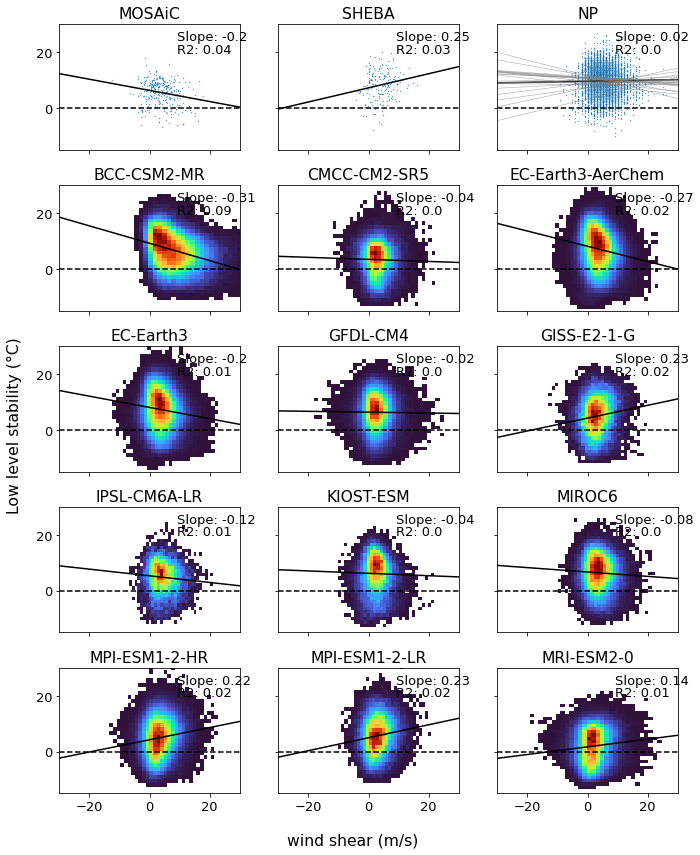

In [51]:
## repeat the above, now looking at the relationship between wind-shear and LLS

cols=3
var_x, var_y = 'wind_shear', 'LLS'
xtxt=0.65
ytxt=0.8
xlims = [-30, 30]
ylims = [-15, 30]
N=12
fig, axs = plt.subplots(nrows=int(N/cols)+1, ncols=cols, figsize=(10,12), sharex=True, sharey=True)
shears_obs = []
i=0
for campaign in Campaigns:
    plt_data = DF_obs[DF_obs['Campaign']==campaign]
    plt_data = plt_data[['wind_shear', 'low_level_stability']].dropna()
    plt_data = plt_data[plt_data['wind_shear']>-500] # SHEBA has some weird values; drop these
    plt_data = plt_data[plt_data['wind_shear']<500]
    #plt_data = plt_data[plt_data['wind_shear']>0]
    axs.flatten()[i].scatter(x =plt_data['wind_shear'], y=plt_data['low_level_stability'], s=0.1)
    
    if not campaign == 'NP':
        shears_obs.append(np.nanmean(plt_data['wind_shear']))
    regression = stats.linregress(x=plt_data['wind_shear'].astype(float), y=plt_data['low_level_stability'].astype(float))
    r2 = np.round((regression.rvalue)**2, 2)
    slope = np.round(regression.slope, 2)
    xs= np.arange(xlims[0], xlims[1], 0.1)
    ys = (regression.slope*xs)+regression.intercept
    axs.flatten()[i].plot(xs, ys, c='black')
    axs.flatten()[i].set_title(campaign)
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    axs.flatten()[i].text(xtxt, ytxt, 'R2: '+str(r2), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    axs.flatten()[i].text(xtxt, ytxt+0.1, 'Slope: '+str(slope), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    #            
    if campaign == 'NP':
        for station in DF_obs[DF_obs['Campaign']=='NP']['station'].unique():
            plt_data = DF_obs[DF_obs['station']==station]
            plt_data = plt_data[['wind_shear', 'low_level_stability']].dropna()
            shears_obs.append(np.nanmean(plt_data['wind_shear']))
            #plt_data = plt_data[plt_data['wind_shear']>0]
            regression = stats.linregress(x=plt_data['wind_shear'].astype(float), y=plt_data['low_level_stability'].astype(float))
            r2 = np.round((regression.rvalue)**2, 2)
            slope = np.round(regression.slope, 2)
            xs= np.arange(xlims[0], xlims[1], 0.1)
            ys = (regression.slope*xs)+regression.intercept
            axs.flatten()[i].plot(xs, ys, c='gray', lw=0.5, alpha=0.75)

    i=i+1


i=3
DF_wind = DF[[var_x, var_y, 'Model']].dropna()
models = DF_wind['Model'].unique()
shears_mods = []
for mod in models:
    plt_data = DF_wind[DF_wind['Model']==mod]
    plt_data = plt_data[[var_x, var_y]].dropna()
    shears_mods.append(np.nanmean(plt_data['wind_shear']))
    sns.histplot(data=plt_data,
                x =var_x, y=var_y,
                ax = axs.flatten()[i],
                cmap='turbo', bins=30)
    regression = stats.linregress(x=plt_data[var_x].astype(float), y=plt_data[var_y].astype(float))
    r2 = np.round((regression.rvalue)**2, 2)
    slope = np.round(regression.slope, 2)
    xs= np.arange(xlims[0], xlims[1], 0.1)
    ys = (regression.slope*xs)+regression.intercept
    axs.flatten()[i].plot(xs, ys, c='black')
    #            
    axs.flatten()[i].set_title(mod)
    axs.flatten()[i].set_xlabel('')
    axs.flatten()[i].set_ylabel('')
    axs.flatten()[i].text(xtxt, ytxt, 'R2: '+str(r2), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    axs.flatten()[i].text(xtxt, ytxt+0.1, 'Slope: '+str(slope), horizontalalignment='left',
     verticalalignment='center', transform=axs.flatten()[i].transAxes)
    
    i=i+1
for ax in axs.flatten():
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.axhline(0, ls='--', color='black')
    
fig.supxlabel('wind shear (m/s)')
fig.supylabel('Low level stability (°C)')
plt.tight_layout()
    #sns.histplot(ax = axs[i], data=DF[DF['Region']==region],
    #            x="LLS", hue="Model", bins=30)
    #i=i+1
plt.savefig('Figures/LLS_wind_shear_Hists_regs.png', dpi=300)